In [3]:
import scanpy as sc
import scipy
import numpy as np
import pandas as pd
import anndata as an
import matplotlib.pyplot as plt
import sklearn
import pickle 
import dataframe_image as dfi
import refined_tangram as tg
import tangram_add_ons as tgx
import seaborn as sns

sc.logging.print_header()
import squidpy as sq
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.3 scipy==1.10.0 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.11
squidpy==1.2.3


## Evaluation

In [ ]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

import pandas as pd
import seaborn as sns

def add_median_labels(ax, pvalues, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median,pvalue in zip(lines[4:len(lines):lines_per_box],pvalues):
        x, y = (data.mean() for data in median.get_data())
        x=1.1
        text = ax.text(x, y, f'{pvalue}', ha='center', va='center', #fontweight='bold',
                        color='#1f77b4', fontsize=8)

In [ ]:
with open('benchmarking/visium_mouse_cortex_modifications.pkl', 'rb') as f:
    metrics = pickle.load(f)
with open('benchmarking/visium_mouse_cortex_constrained.pkl', 'rb') as f:
    metrics2 = pickle.load(f)
with open('benchmarking/visium_mouse_cortex_constrained_preprocess.pkl', 'rb') as f:
    metrics3 = pickle.load(f)
with open('benchmarking/visium_mouse_cortex_cytospace.pkl', 'rb') as f:
    metrics4 = pickle.load(f)
for m in metrics.keys():
    metrics[m]["constrained"] = np.array(metrics2[m]["constrained"])
    if m in metrics4.keys():
        for model in metrics4[m].keys():
            metrics[m][model] = metrics4[m][model]
    if m in metrics3.keys():
        for model in metrics3[m].keys():
            metrics[m][model] = metrics3[m][model]

In [ ]:
with open('benchmarking/seqfish_mouse_embryo_modifiations.pkl', 'rb') as f:
    metrics_seqfish = pickle.load(f)
with open('benchmarking/merfish_mouse_hypothalamus_modifiations.pkl', 'rb') as f:
    metrics_merfish = pickle.load(f)
with open('benchmarking/seqfish+_mouse_cortex_modifiations.pkl', 'rb') as f:
    metrics_seqfishP = pickle.load(f)
for m in metrics_seqfish.keys():
    metrics[m+"_seqfish"] = dict()
    for model in metrics_seqfish[m].keys():
        metrics[m+"_seqfish"][model] = metrics_seqfish[m][model]
    metrics[m+"_seqfishP"] = dict()
    for model in metrics_seqfishP[m].keys():
        metrics[m+"_seqfishP"][model] = metrics_seqfishP[m][model]
    metrics[m+"_merfish"] = dict()
    for model in metrics_merfish[m].keys():
        metrics[m+"_merfish"][model] = metrics_merfish[m][model]

In [31]:
#preprocess
m = "cell_map_cross_entropy"
for n in ["_seqfish","_merfish","_seqfishP"]:
    for model in metrics[m+n].keys():
        metrics[m+n][model] = 1-(np.array(metrics[m+n][model]).mean(axis=0) / np.array(metrics[m+n][model]).mean(axis=0).max())
m = "ct_map_cross_entropy"
for n in ["_seqfish","_merfish","_seqfishP"]:
    for model in metrics[m+n].keys():
        metrics[m+n][model] = 1-(np.array(metrics[m+n][model]).mean(axis=0) / np.array(metrics[m+n][model]).mean(axis=0).max())
m = "gene_expr_cosine_sim"
for n in ["","_seqfish","_merfish","_seqfishP"]:
    for model in metrics[m+n].keys():
        metrics[m+n][model] = np.array(metrics[m+n][model]).mean(axis=0)
m = 'all_gene_expr_cosine_sim'
for n in ["","_seqfish","_merfish","_seqfishP"]:
    for model in metrics[m+n].keys():
        metrics[m+n][model] = np.array(metrics[m+n][model]).mean(axis=0)
for m in ['cell_map_vote_entropy',
            'cell_map_consensus_entropy',
            ]:
    for n in ["","_seqfish","_merfish","_seqfishP"]:
        for model in metrics[m+n].keys():
            metrics[m+n][model] = 1-np.array(metrics[m+n][model])
for m in ['ct_map_vote_entropy',
            'ct_map_consensus_entropy',
            ]:
    for n in ["","_seqfish","_merfish","_seqfishP"]:
        for model in metrics[m+n].keys():
            metrics[m+n][model] = 1-np.array(metrics[m+n][model]).mean(0)

In [ ]:
import copy
df = copy.deepcopy(metrics)

for m in metrics.keys():
    for model in metrics[m]:
        df[m][model] = np.nanmean(df[m][model])

df = pd.DataFrame(df)

In [ ]:
metric_names_basis = [
 "all_g_gene_expr_corr",	
 'c_cell_map_corr',
 'cell_map_vote_entropy',
 'cell_map_consensus_entropy',
 "c_ct_map_corr",
 'ct_map_vote_entropy',
 'ct_map_consensus_entropy',
 ]
metric_names = ['all_gene_expr_cosine_sim',
 'all_gene_expr_cosine_sim_seqfish',
 'all_gene_expr_cosine_sim_merfish',
 'all_gene_expr_cosine_sim_seqfishP',
 "cell_map_cross_entropy_seqfish",
 "cell_map_cross_entropy_merfish",
 "cell_map_cross_entropy_seqfishP",
 "ct_map_cross_entropy_seqfish",
 "ct_map_cross_entropy_merfish",
 "ct_map_cross_entropy_seqfishP"]
for m in metric_names_basis:
    metric_names += [m,m+"_seqfish",m+"_merfish",m+"_seqfishP"]
metric_labels = {m : "Visium" for m in ["all_gene_expr_cosine_sim","all_g_gene_expr_corr",	'c_cell_map_corr','cell_map_vote_entropy', 'cell_map_consensus_entropy',
                                        'c_ct_map_corr','ct_map_vote_entropy', 'ct_map_consensus_entropy']}
metric_labels.update({m+"_merfish" : "MERFISH" for m in ["all_gene_expr_cosine_sim","all_g_gene_expr_corr",	'c_cell_map_corr','cell_map_vote_entropy', 'cell_map_consensus_entropy','cell_map_cross_entropy','ct_map_cross_entropy','c_ct_map_corr','ct_map_vote_entropy', 'ct_map_consensus_entropy']})
metric_labels.update({m+"_seqfish" : "SeqFISH" for m in ["all_gene_expr_cosine_sim","all_g_gene_expr_corr",	'c_cell_map_corr','cell_map_vote_entropy', 'cell_map_consensus_entropy','cell_map_cross_entropy','ct_map_cross_entropy','c_ct_map_corr','ct_map_vote_entropy', 'ct_map_consensus_entropy']})
metric_labels.update({m+"_seqfishP" : "SeqFISH+" for m in ["all_gene_expr_cosine_sim","all_g_gene_expr_corr",	'c_cell_map_corr','cell_map_vote_entropy', 'cell_map_consensus_entropy','cell_map_cross_entropy','ct_map_cross_entropy','c_ct_map_corr','ct_map_vote_entropy', 'ct_map_consensus_entropy']})


models = ['random', 'orig', 
          'hvg', 'ctg', 'svg', 'hvg+svg+ctg', 'spapros',
          'neighborhood_cosine_similarity', 'ct_island', 'getis_ord_g_star', 'geary_C', "moran_I", 
          'entropy_reg', 'l1_reg', 'l2_reg', 
          'constrained','constrained_preprocess','cytospace_preprocess',  
          "combi", "constrained_combi", 'cytospace_combi',
          ]
model_labels = {"random" : "$\\it{Random\ assignment}$", 
                "orig" : "$\\it{Vanilla}$",
                'hvg' : "scHVGs", 
                'ctg' : "CTGs", 
                'svg' : "SVGs", 
                'hvg+svg+ctg' : "scHVGs + CTGs + SVGs",
                'spapros' : "Spapros genes",
                "neighborhood_cosine_similarity" : "Spatial weighted gene expression", 
                "ct_island" : "Cell type islands enforcement", 
                "getis_ord_g_star" : "Getis-Ord G* preservation", 
                "moran_I" : "Moran's I preservation", 
                "geary_C" : "Geary's C preservation", 
                'entropy_reg' : "Entropy regularization", 
                'l1_reg' : "L1 regularization", 
                'l2_reg' : "L2 regularization", 
                "constrained":"Cell filtering during training", 
                "constrained_preprocess":"Cell filtering preprocessing", 
                "cytospace_preprocess": "Cell sampling preprocessing",
                "combi" : "Combination",
                "constrained_combi" : "Combination + \ncell filtering preprocessing",
                "cytospace_preprocess" : "Cell sampling preprocessing",
                'cytospaceT_combi' : "Combination + \nCell sampling preprocessing",
                }

In [ ]:
df_subset = df.loc[:, metric_names].copy().abs()

In [ ]:
pvalues = {}
for i in range(len(metric_names)):
    m = metric_names[i]
    pvalues[m] = []
    for mo in models:
        if mo in metrics[m].keys():
            _,pvalue = scipy.stats.mannwhitneyu(metrics[m][mo], metrics[m]["orig"], alternative="greater")
            pvalues[m].append(convert_pvalue_to_asterisks(pvalue))
        else:
            pvalues[m].append("")
pvalues_df = pd.DataFrame(pvalues, index=models)

In [47]:
metric_names0 = [
 'cell_map_cross_entropy_seqfish',
 'cell_map_cross_entropy_merfish',
 'cell_map_cross_entropy_seqfishP',
 'ct_map_cross_entropy_seqfish',
 'ct_map_cross_entropy_merfish',
 'ct_map_cross_entropy_seqfishP',
 ]
metric_names1 = [
 'all_gene_expr_cosine_sim',
 'all_gene_expr_cosine_sim_seqfish',
 'all_gene_expr_cosine_sim_merfish',
 'all_gene_expr_cosine_sim_seqfishP',
 'cell_map_cross_entropy_seqfishP',
 'cell_map_cross_entropy_merfish',
 'cell_map_cross_entropy_seqfish',
 'ct_map_cross_entropy_seqfishP',
 'ct_map_cross_entropy_merfish',
 'ct_map_cross_entropy_seqfish',
 ]
metric_names2 = [
 'all_g_gene_expr_corr',
 'all_g_gene_expr_corr_seqfish',
 'all_g_gene_expr_corr_merfish',
 'all_g_gene_expr_corr_seqfishP',
 'c_cell_map_corr',
 'c_cell_map_corr_seqfish',
 'c_cell_map_corr_merfish',
 'c_cell_map_corr_seqfishP',
 'c_ct_map_corr',
 'c_ct_map_corr_seqfish',
 'c_ct_map_corr_merfish',
 'c_ct_map_corr_seqfishP',
 ]
metric_names3 = [
 'cell_map_vote_entropy',
 'cell_map_vote_entropy_seqfish',
 'cell_map_vote_entropy_merfish',
 'cell_map_vote_entropy_seqfishP',
 'ct_map_vote_entropy',
 'ct_map_vote_entropy_seqfish',
 'ct_map_vote_entropy_merfish',
 'ct_map_vote_entropy_seqfishP',
 ]

metric_names4 = [
 'cell_map_consensus_entropy',
 'cell_map_consensus_entropy_seqfish',
 'cell_map_consensus_entropy_merfish',
 'cell_map_consensus_entropy_seqfishP',
 'ct_map_consensus_entropy',
 'ct_map_consensus_entropy_seqfish',
 'ct_map_consensus_entropy_merfish',
 'ct_map_consensus_entropy_seqfishP',
 ]
metric_names5 = ["runtimes"]

In [48]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_cmap0 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "orange"])
custom_cmap3 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "xkcd:pumpkin orange"])
custom_cmap4 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "orangered"]) #"xkcd:bright orange"
custom_cmap5 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "white"])

### Gene sets

In [ ]:
runtimes = pd.DataFrame({
            "random" : [0] * 9,
            "orig" : [35.82010269165039, 35.8702826499939, 35.81853222846985, 35.78240752220154, 35.791804790496826, 35.79258918762207, 35.802809715270996, 35.77779579162598, 35.79166030883789],
            "hvg": [9.557812690734863, 9.464809894561768, 9.493047952651978, 9.602404356002808, 9.542037963867188, 9.654044151306152, 9.51349687576294, 9.759645700454712, 9.509783267974854],
            "ctg" : [8.714023113250732, 8.681432008743286, 8.69970417022705, 8.678237915039062, 8.693213939666748, 8.72935175895691, 8.69254207611084, 8.687475442886353, 8.705013036727905],
            "svg" : [7.427520751953125, 7.214260101318359, 7.254720211029053, 7.216355323791504, 7.214090824127197, 7.241504907608032, 7.240078926086426, 7.367404937744141, 7.21972918510437],
            "hvg+svg+ctg" : [12.443064451217651, 12.419925928115845, 12.418939113616943, 12.466089725494385, 12.542001008987427, 12.626966714859009, 12.524576663970947, 12.529202461242676, 12.550411701202393],
            "spapros" : [8.531982421875, 8.529884338378906, 8.53866171836853, 8.52337908744812, 8.532057285308838, 8.611390352249146, 8.551242113113403, 8.565473318099976, 8.637438297271729],
           })

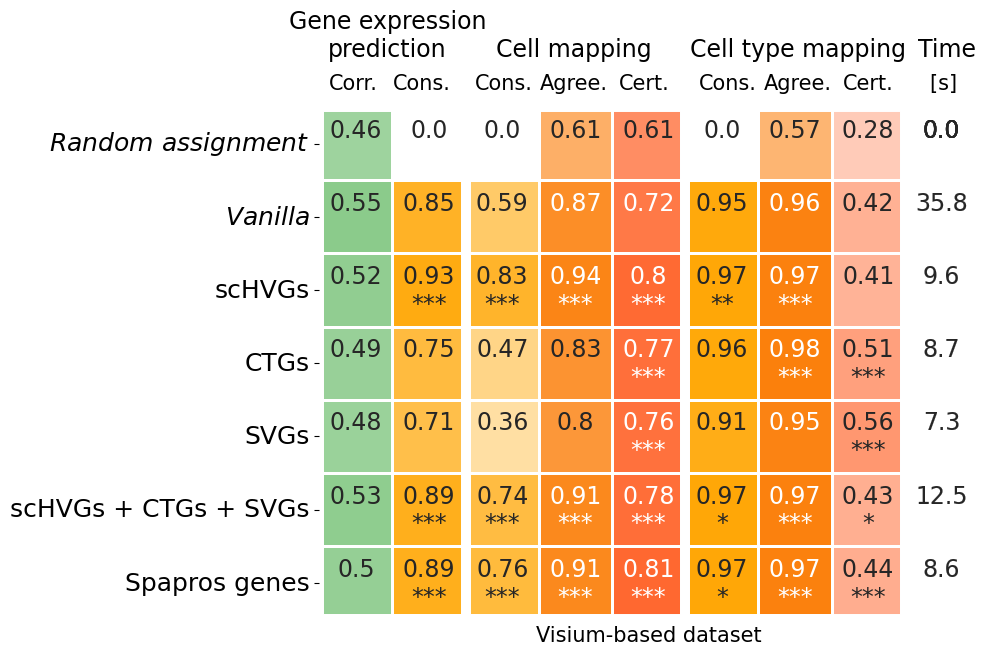

In [ ]:
from matplotlib.patches import Rectangle
models2 = ['random', 'orig', 
          'hvg', 'ctg', 'svg', 'hvg+svg+ctg', 'spapros'
          ]
metric_names22 = ['all_gene_expr_cosine_sim',
 'all_g_gene_expr_corr',
 'c_cell_map_corr',
 'cell_map_vote_entropy',
 'cell_map_consensus_entropy',
 'c_ct_map_corr',
 'ct_map_vote_entropy',
 'ct_map_consensus_entropy']
df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
df_subset2["runtimes"] = runtimes.mean().round(decimals=1)#.astype(int)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()
pvalues_df2["runtimes"] = ""

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*(len(metric_names22)+1)+4, 1*len(models2)+0.8), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Gene expression\nprediction","Cell mapping","Cell type mapping","Time"]
group_labels2 = ["Correctness","Consistency", "Consistency","Agreement", "Certainty","Consistency", "Agreement", "Certainty"]
group_labels2 = ["Corr.","Cons.", "Cons.","Agree.", "Cert.","Cons.", "Agree.", "Cert.","[s] "]
group_positions = [[0,1],[2,4],[5,7],[8,8]]
ncols = len(metric_names22) + 1 #rt
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.3]
        for i in range(group_positions[g_idx][0], group_positions[g_idx][1]+1):
            ax.text(
                i-group_positions[g_idx][0]  + 0.5, -0.01 + (y) * 1.5,#i-group_positions[g_idx][0]  + 1, (y) * 1.5, #+ (i-group_positions[g_idx][0])*0.1
                group_labels2[i],
                ha='center',
                color="black", size=15,
            ) 
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.43, group, ha="center", va="bottom", 
            color="black",
            size=17,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4,metric_names5],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4,custom_cmap5]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.add_patch(Rectangle((0, 0), 2, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((2, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((5, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((8, 0), 1, 7, fill=False, edgecolor='white', lw=7))
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.set_xlabel('Visium-based dataset', fontsize=15)

### Cell subset

In [50]:
from matplotlib.patches import Rectangle

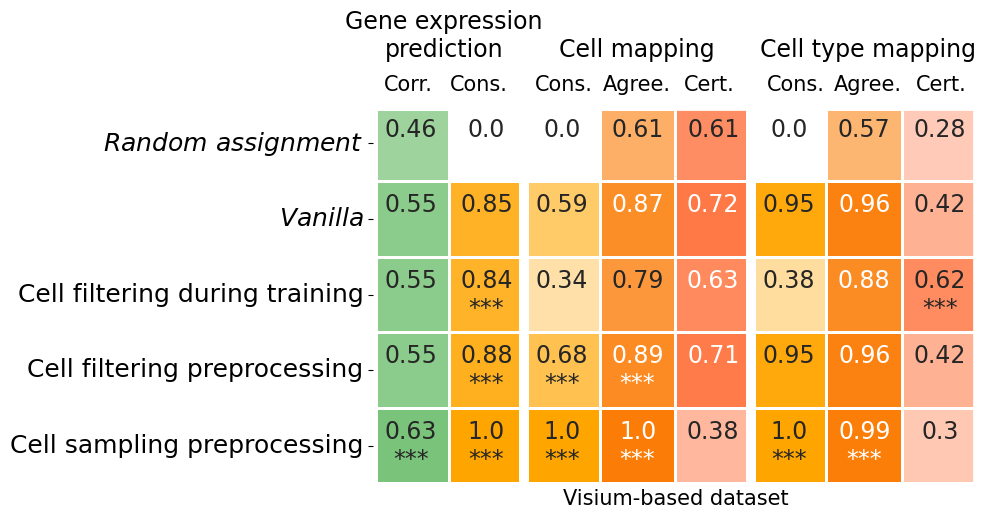

In [ ]:
models2 = ['random', 'orig', 
         'constrained', 'constrained_preprocess', 'cytospace_preprocess', 
          ]
metric_names22 = ['all_gene_expr_cosine_sim',
 'all_g_gene_expr_corr',
 'c_cell_map_corr',
 'cell_map_vote_entropy',
 'cell_map_consensus_entropy',
 'c_ct_map_corr',
 'ct_map_vote_entropy',
 'ct_map_consensus_entropy']
df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+3.8, 1*len(models2)+1), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Gene expression\nprediction","Cell mapping","Cell type mapping"]
group_labels2 = ["Correctness","Consistency", "Consistency","Agreement", "Certainty","Consistency", "Agreement", "Certainty"]
group_labels2 = ["Corr.","Cons.", "Cons.","Agree.", "Cert.","Cons.", "Agree.", "Cert."]
group_positions = [[0,1],[2,4],[5,7]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.3] 
        for i in range(group_positions[g_idx][0], group_positions[g_idx][1]+1):
            ax.text(
                i-group_positions[g_idx][0]  + 0.5, -0.01 + (y) * 1.5,#i-group_positions[g_idx][0]  + 1, (y) * 1.5, #+ (i-group_positions[g_idx][0])*0.1
                group_labels2[i],
                ha='center',# va="bottom", 
                color="black", size=15
            ) 
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.43, group, ha="center", va="bottom", 
            color="black",
            size=17,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.add_patch(Rectangle((0, 0), 2, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((2, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((5, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.set_xlabel('Visium-based dataset', fontsize=15)

### Neighborhood information

Text(0.5, 1.13, 'Gene expression prediction')

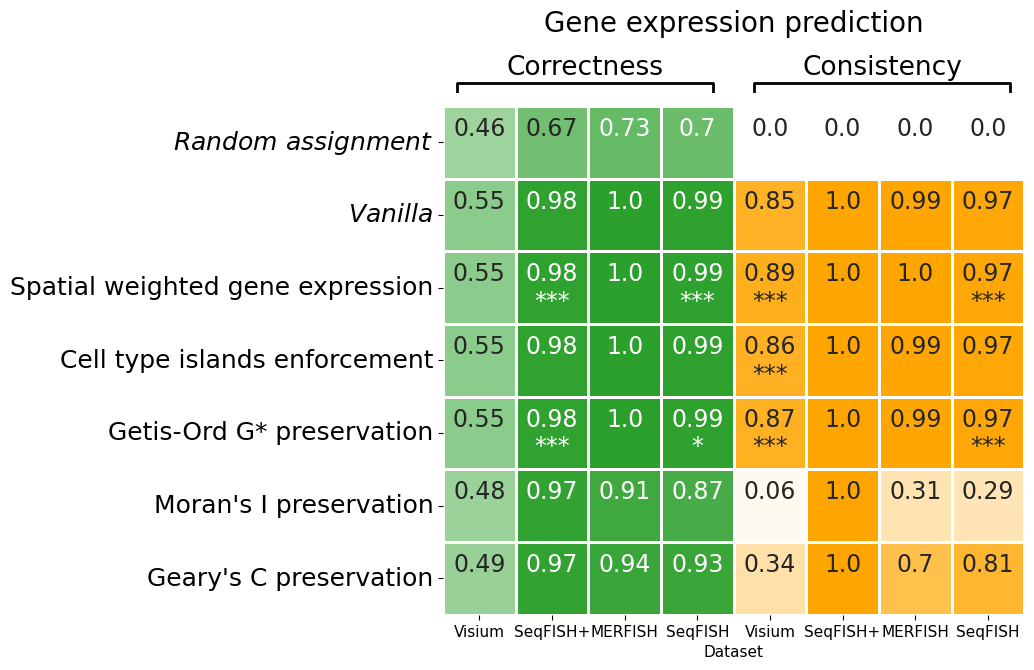

In [ ]:
metric_names222 = ['all_gene_expr_cosine_sim', 'all_g_gene_expr_corr']
metric_names22 = [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
          'neighborhood_cosine_similarity', 'ct_island', 'getis_ord_g_star', 'moran_I', "geary_C"
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+3.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency"]
group_positions = [[0,3],[4,7]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Gene expression prediction",fontdict={"fontsize":20}, x=0.5,y=1.13)

Text(0.5, 1.13, 'Cell mapping')

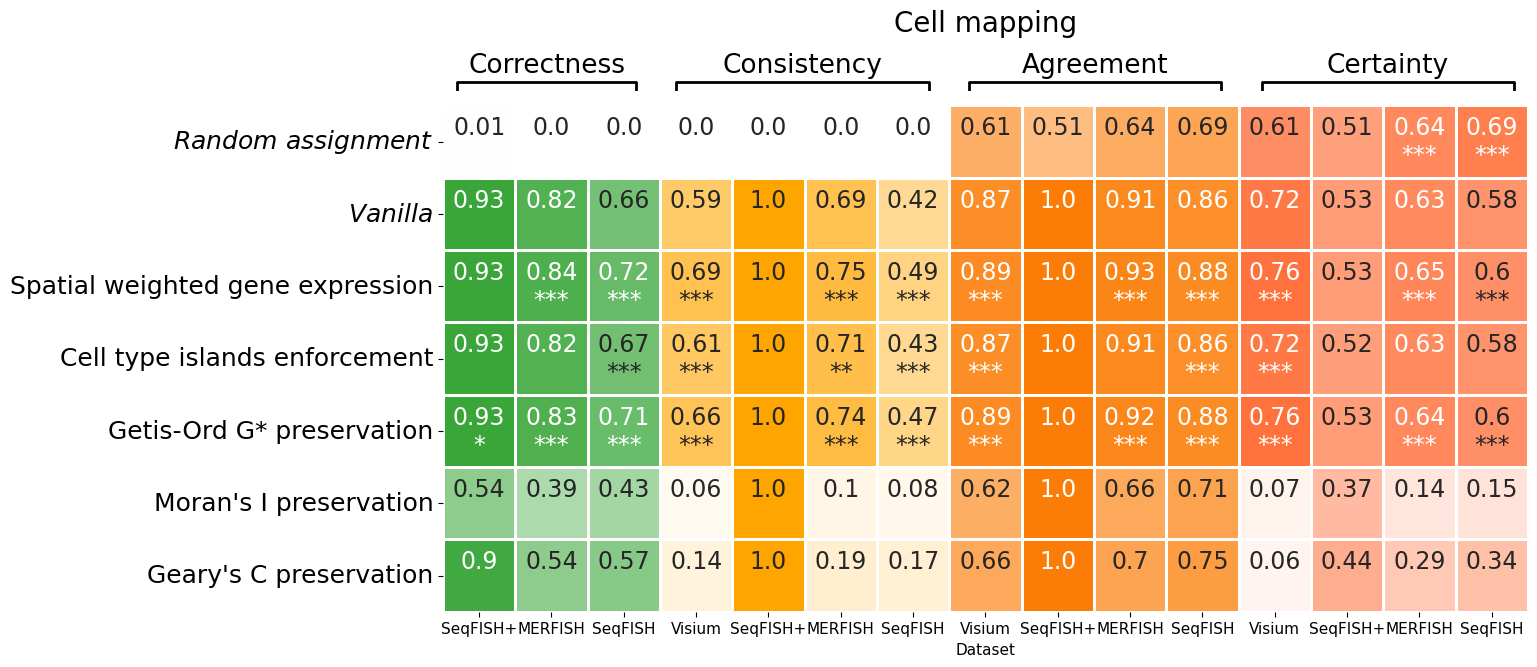

In [ ]:
metric_names22 = ["cell_map_cross_entropy"+a for a in ["_seqfishP","_merfish", "_seqfish"]]
metric_names222 = [
 'c_cell_map_corr',
 'cell_map_vote_entropy',
 'cell_map_consensus_entropy'
]
metric_names22 += [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
          'neighborhood_cosine_similarity', 'ct_island', 'getis_ord_g_star', 'moran_I', "geary_C"
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+6.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell mapping",fontdict={"fontsize":20}, x=0.5,y=1.13)

Text(0.5, 1.13, 'Cell type mapping')

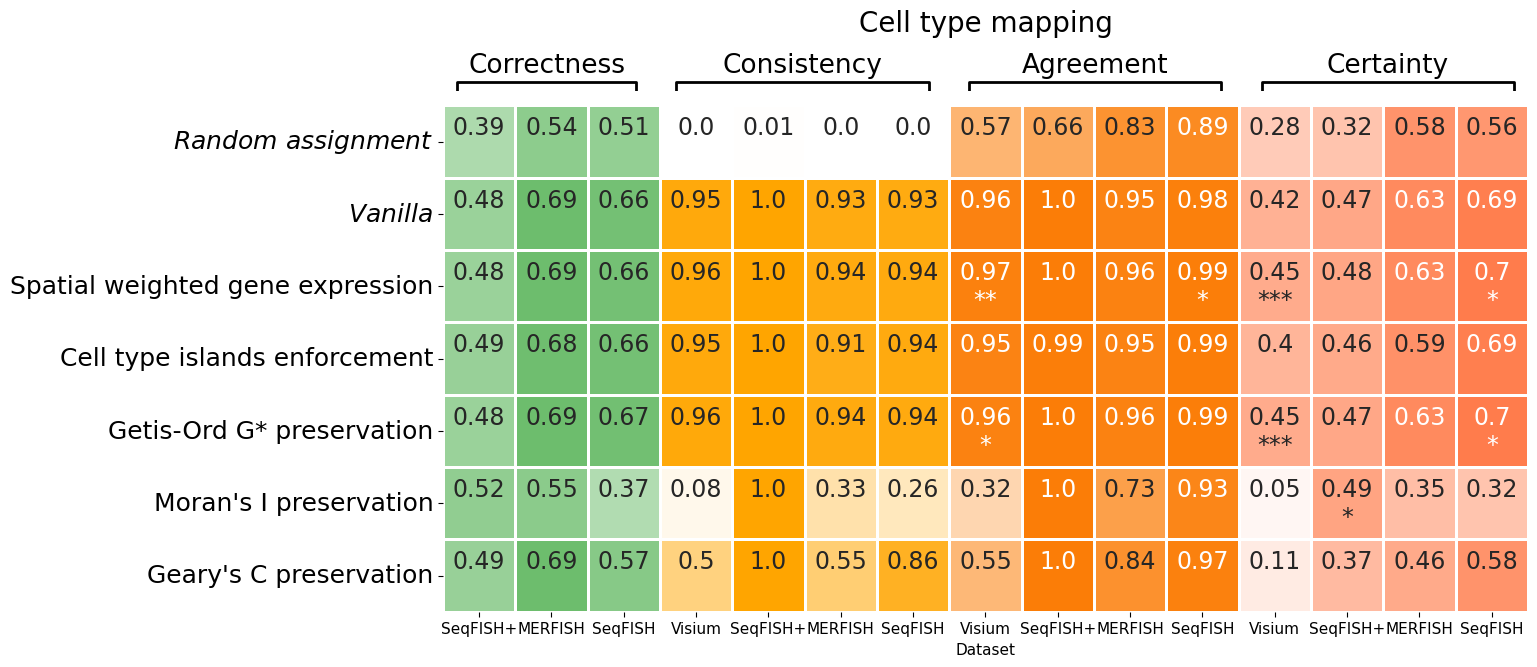

In [ ]:
metric_names22 = ["ct_map_cross_entropy"+a for a in ["_seqfishP","_merfish", "_seqfish"]]
metric_names222 = [
 'c_ct_map_corr',
 'ct_map_vote_entropy',
 'ct_map_consensus_entropy'
]
metric_names22 += [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
          'neighborhood_cosine_similarity', 'ct_island', 'getis_ord_g_star', 'moran_I', "geary_C"
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+6.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell type mapping",fontdict={"fontsize":20}, x=0.5,y=1.13)

### Regularization

Text(0.5, 1.17, 'Gene expression prediction')

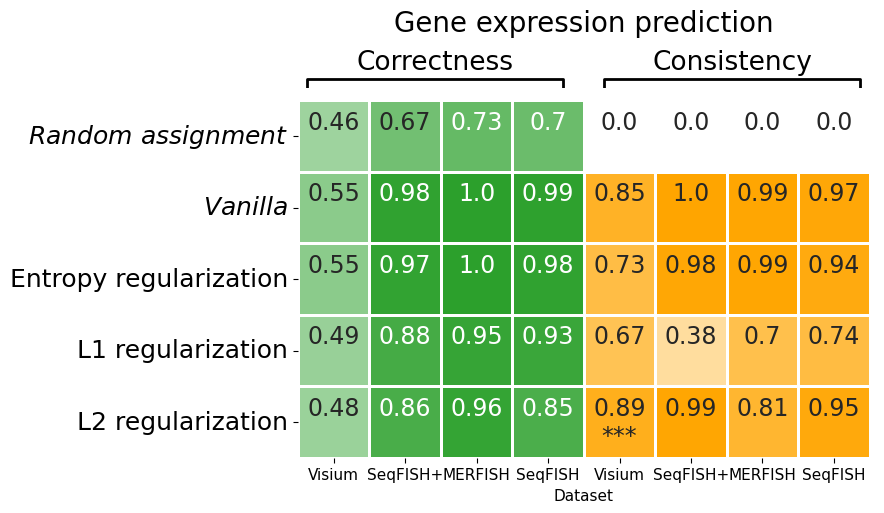

In [ ]:
metric_names222 = ['all_gene_expr_cosine_sim', 'all_g_gene_expr_corr']
metric_names22 = [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
          'entropy_reg', 'l1_reg', 'l2_reg',
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+3.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency"]
group_positions = [[0,3],[4,7]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Gene expression prediction",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell mapping')

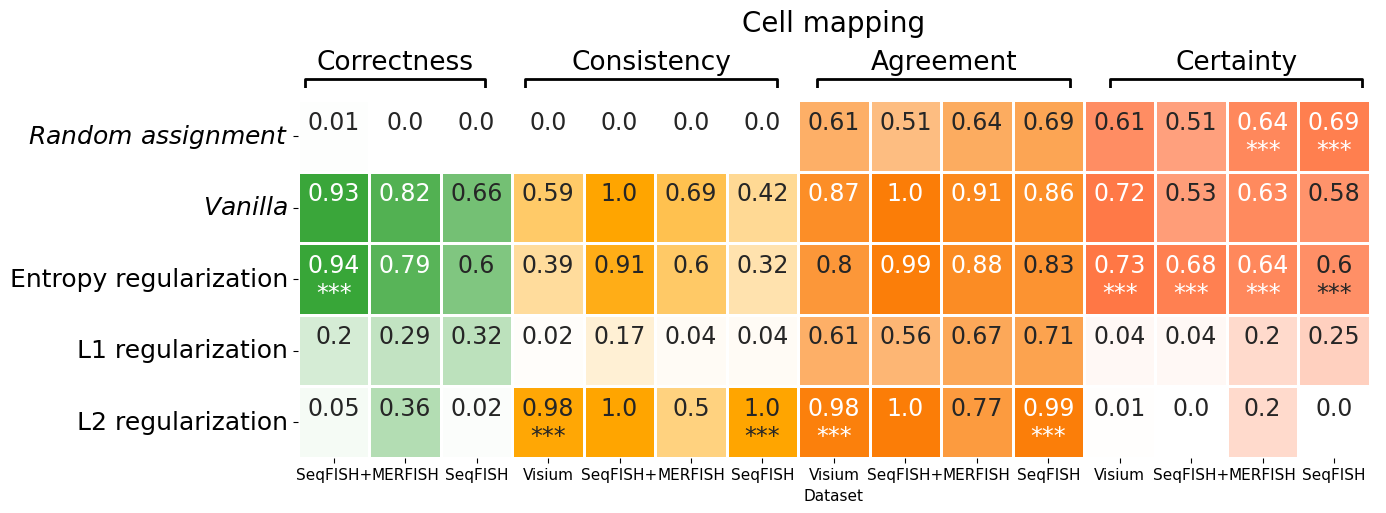

In [ ]:
metric_names22 = ["cell_map_cross_entropy"+a for a in ["_seqfishP","_merfish", "_seqfish"]]
metric_names222 = [
 'c_cell_map_corr',
 'cell_map_vote_entropy',
 'cell_map_consensus_entropy'
]
metric_names22 += [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
          'entropy_reg', 'l1_reg', 'l2_reg',
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+6.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
    #ax.set_xlabel('Dataset', fontsize=17)
plt.title("Cell mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell type mapping')

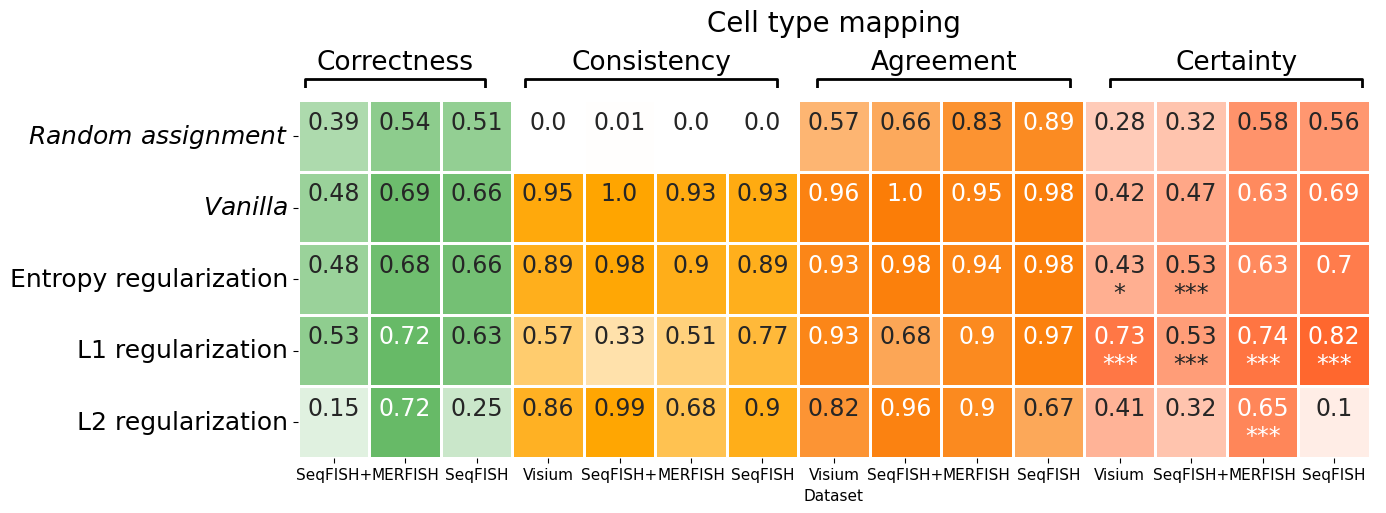

In [ ]:
metric_names22 = ["ct_map_cross_entropy"+a for a in ["_seqfishP","_merfish", "_seqfish"]]
metric_names222 = [
 'c_ct_map_corr',
 'ct_map_vote_entropy',
 'ct_map_consensus_entropy'
]
metric_names22 += [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
          'entropy_reg', 'l1_reg', 'l2_reg',
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+6.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell type mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)

### Combi

Text(0.5, 1.17, 'Gene expression prediction')

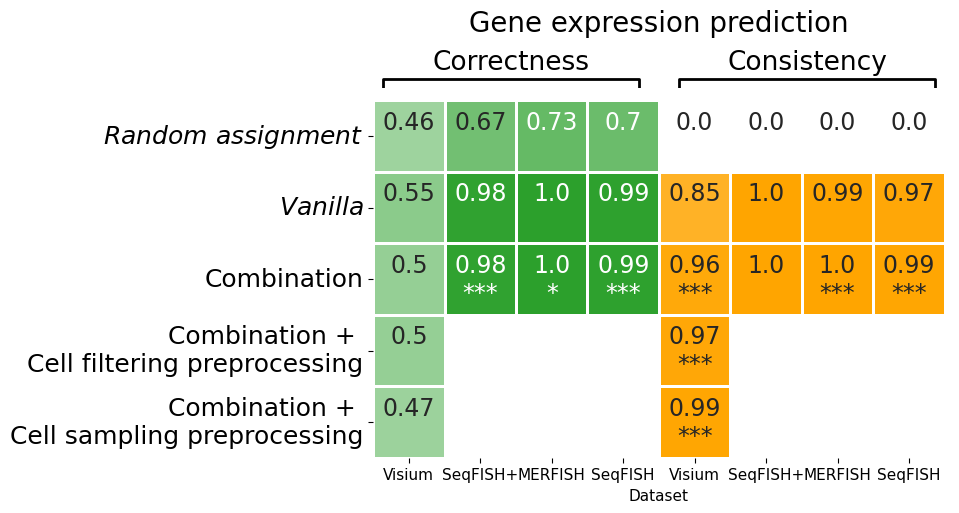

In [ ]:
metric_names222 = ['all_gene_expr_cosine_sim', 'all_g_gene_expr_corr']
metric_names22 = [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
           "combi","constrained_combi", 'cytospace_combi'
          ]

df_subset2 = df_subset.loc[models2,metric_names22].round(decimals=2).copy()
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+3.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency"]
group_positions = [[0,3],[4,7]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Gene expression prediction",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell mapping')

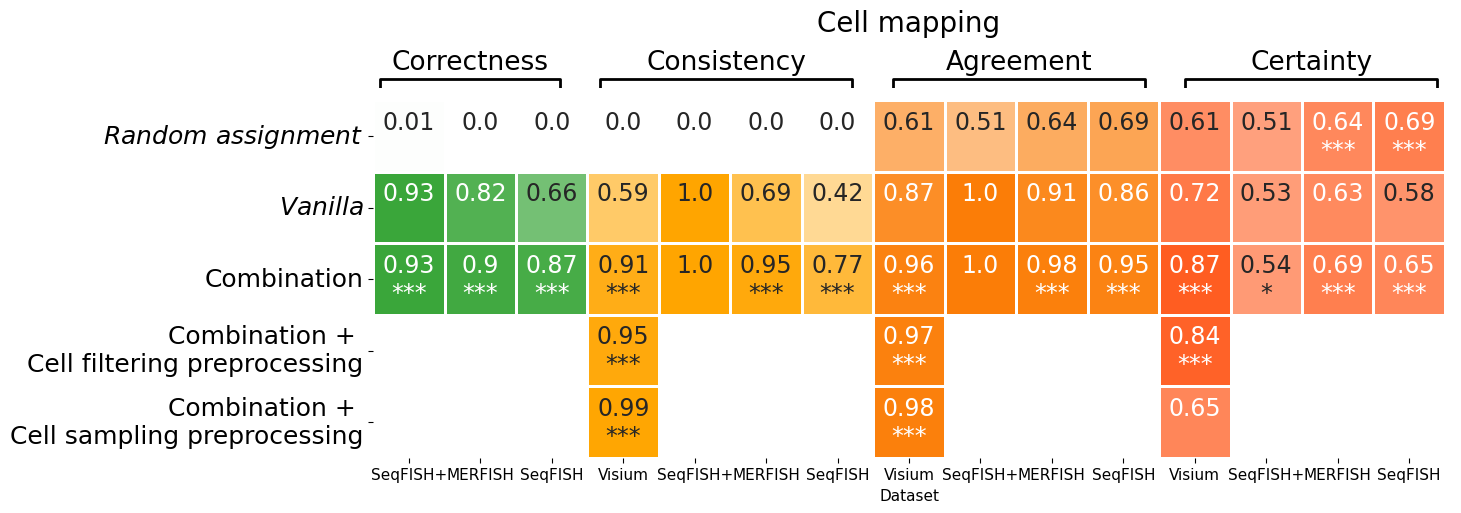

In [ ]:
metric_names22 = ["cell_map_cross_entropy"+a for a in ["_seqfishP","_merfish", "_seqfish"]]
metric_names222 = [
 'c_cell_map_corr',
 'cell_map_vote_entropy',
 'cell_map_consensus_entropy'
]
metric_names22 += [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
           "combi","constrained_combi", 'cytospace_combi'
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+6.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell type mapping')

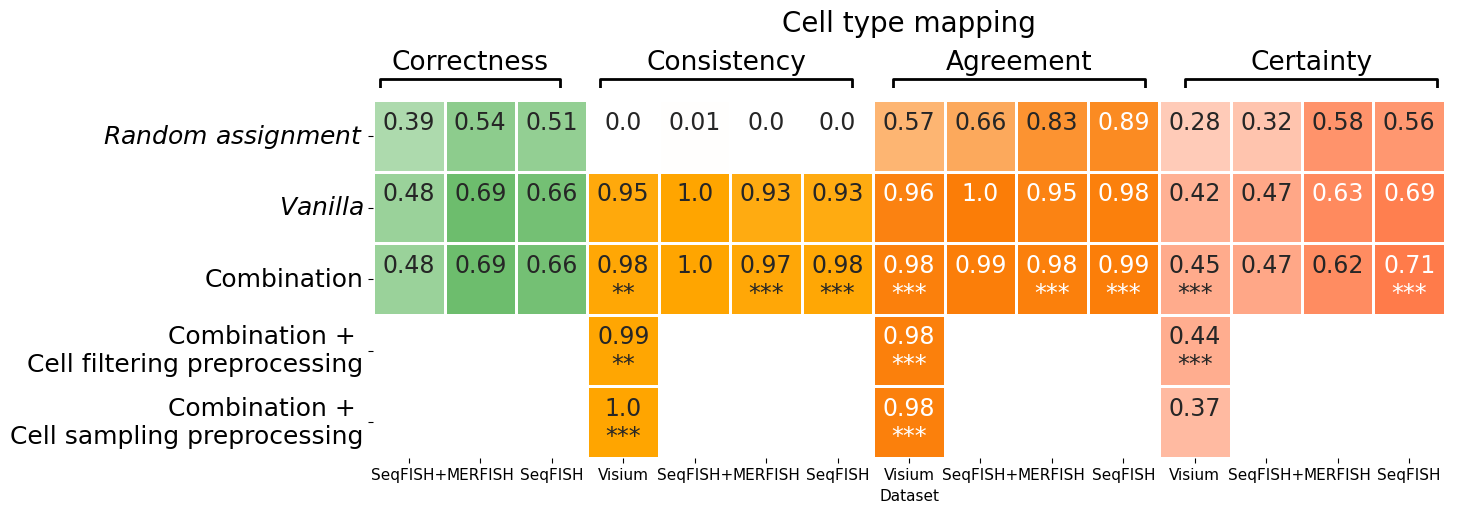

In [ ]:
metric_names22 = ["ct_map_cross_entropy"+a for a in ["_seqfishP","_merfish", "_seqfish"]]
metric_names222 = [
 'c_ct_map_corr',
 'ct_map_vote_entropy',
 'ct_map_consensus_entropy'
]
metric_names22 += [m+a for m in metric_names222 for a in ["","_seqfishP","_merfish", "_seqfish"]]

models2 = ['random', 'orig', 
           "combi","constrained_combi", 'cytospace_combi'
          ]

df_subset2 = df_subset.loc[models2,metric_names22].copy().round(decimals=2)
pvalues_df2 = pvalues_df.loc[models2,metric_names22].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metric_names22)+6.5, 1*len(models2)+0.6), 
                       sharey=True,)#layout='constrained')
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metric_names22)
nrows = len(models2) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]  # [0,0.12]#[0,0.3]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(metric_names22)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_subset2.round(decimals=2).astype("str") + "\n" + pvalues_df2, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models2],
                xticklabels = [metric_labels[mo] for mo in metric_names22],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell type mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)

## Hyperparameter tuning

In [9]:
df = pd.read_csv("hyperparameter/hyperparam_tuning_Spapros.csv",index_col=0)
df

,cell_map_corr,cell_map_vote_entropy,cell_map_consensus_entropy,gene_corr,val_gene_score,val_sp_sparsity_weighted_score,val_auc_score,val_prob_entropy,timestamp,checkpoint_dir_name,...,config/learning_rate,config/lambda_g1,config/lambda_g2,config/lambda_d,config/lambda_r,config/lambda_l2,config/lambda_neighborhood_g1,config/lambda_ct_islands,config/lambda_getis_ord,logdir
0,0.275381,0.100038,1.000000,1.000000,0.473240,0.716399,0.632862,0.966772,1732837181,NaN,...,0.953589,0.574847,0.397710,0.351368,6.006613e-09,3.162183e-04,0.986274,0.456249,0.587608,9d382377
1,0.697110,0.063419,0.115547,0.998080,0.473993,0.716911,0.633571,0.911889,1732837246,NaN,...,0.260913,0.457221,0.116556,0.387623,2.299081e-18,5.796728e-20,0.813820,0.486007,0.836863,fa4fae09
2,0.571005,0.083851,0.134829,0.997269,0.473759,0.717087,0.633534,0.914365,1732837309,NaN,...,0.078299,0.300466,0.664883,0.332220,2.647957e-09,2.873784e-13,0.272255,0.142102,0.863553,4dd4f8eb
3,0.715369,0.062416,0.134096,0.998387,0.474217,0.717391,0.633933,0.913410,1732837374,NaN,...,0.160602,0.963271,0.708497,0.815533,1.102309e-11,2.921717e-17,0.159393,0.513770,0.531630,0188bdff
4,0.633976,0.080258,1.000000,1.000000,0.473212,0.716398,0.632858,0.942379,1732837439,NaN,...,0.337806,0.330412,0.331825,0.236341,3.177144e-16,7.451702e-06,0.084303,0.555702,0.407500,36036de9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.116590,0.128782,1.000000,1.000000,0.473128,0.716368,0.632821,0.915310,1732982983,NaN,...,0.010070,0.629929,0.958091,0.562092,1.349148e-16,8.762633e-05,0.246061,0.017509,0.831731,96610dda
1996,0.969679,0.025104,1.000000,1.000000,0.473170,0.716366,0.632826,0.919364,1732983063,NaN,...,0.058188,0.729159,0.396876,0.464900,4.810504e-13,5.000289e-05,0.819763,0.855663,0.836779,2ab2c5db
1997,0.036508,0.180924,0.182491,0.990239,0.473932,0.717291,0.633729,0.908230,1732983139,NaN,...,0.090247,0.585028,0.999527,0.837011,4.508843e-06,1.310105e-16,0.127286,0.057110,0.780582,e58e9d7b
1998,0.029344,0.182635,0.183796,0.989543,0.473834,0.717184,0.633619,0.907954,1732983218,NaN,...,0.090251,0.215357,0.096516,0.538448,4.232210e-06,1.203623e-13,0.717406,0.018045,0.299636,3985deec


In [10]:
for m in ["cell_map_vote_entropy",
          "cell_map_consensus_entropy"]:
    df[m] = 1 - df[m]

In [11]:
xlabel = {
    "cell_map_corr" : "Cell mapping\nconsistency",
    "cell_map_vote_entropy" : "Cell mapping\nagreement",
    "cell_map_consensus_entropy" : "Cell mapping\ncertainty",
    "gene_corr" : "Gene expr prediction\nconsistency",
    "val_gene_score" : "Gene expr prediction\ncorrectness",
    "val_sp_sparsity_weighted_score" : "gene sp\nsparsity\ncosine\nsimilarity",
    "val_prob_entropy" : "mapping\nentropy",
    "config/lambda_d" : "$\lambda_\mathrm{cell\ densities}$",
    "config/lambda_g1" : "$\lambda_\mathrm{gene\ expr1}$",
    "config/lambda_g2" : "$\lambda_\mathrm{gene\ expr2}$",
    "config/lambda_r" : "$\lambda_\mathrm{entropy\ reg}$",
    "config/lambda_l1" : "l1 regularization",
    "config/lambda_l2" : "$\lambda_\mathrm{L2\ reg}$",
    "config/lambda_neighborhood_g1" : "$\lambda_\mathrm{spatial\ gene\ expr}$",
    "config/lambda_ct_islands" : "$\lambda_\mathrm{ct\ islands}$",
    "config/lambda_getis_ord" : "$\lambda_{\mathrm{Getis-Ord\ } G*}$",
    "config/learning_rate" : "lr",
}
xlimit = {
    "val_gene_score" : [-0.1,1.1],
    "cell_map_corr" : [-0.1,1.1],
    "gene_corr" : [-0.1,1.1],
    "cell_map_vote_entropy" : [-0.1,1.1],
    "cell_map_consensus_entropy" : [-0.1,1.1],
    "val_sp_sparsity_weighted_score" : [-0.1,1.1],
    "val_prob_entropy" : [-0.1,1.1],
    "config/lambda_d" : [-0.1,1.1],
    "config/lambda_g1" : [-0.1,1.1],
    "config/lambda_g2" : [-0.1,1.1],
    "config/lambda_r" : [0.5e-20, 0.0075], #1e-10, 1e-3
    "config/lambda_l1" : [0.5e-20, 0.0075],
    "config/lambda_l2" : [0.5e-20, 0.0075],
    "config/lambda_neighborhood_g1" :[-0.1,1.1],
    "config/lambda_ct_islands" : [-0.1,1.1], 
    "config/lambda_getis_ord" : [-0.1,1.1],
    "config/learning_rate" : [0.005, 1.5]
}

df1 = df.sort_values("val_gene_score",ascending=False)[:20].copy()
df1["metric"] = xlabel["val_gene_score"]
df6 = df.sort_values("gene_corr",ascending=False)[:20].copy()
df6["metric"] = xlabel["gene_corr"]
df7 = df.sort_values("cell_map_corr",ascending=False)[:20].copy()
df7["metric"] = xlabel["cell_map_corr"]
df4 = df.sort_values("cell_map_vote_entropy",ascending=False)[:20].copy()
df4["metric"] = xlabel["cell_map_vote_entropy"]
df5 = df.sort_values("cell_map_consensus_entropy",ascending=False)[:20].copy()
df5["metric"] = xlabel["cell_map_consensus_entropy"]
df_top = pd.concat([df1,df6,df7,df4,df5])

(-0.05, 1.05)

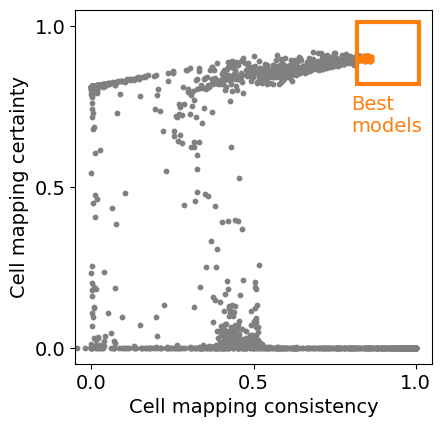

In [13]:
import matplotlib.patches as patches
 
ax = df.plot(x="cell_map_corr",y="cell_map_consensus_entropy",kind="scatter",s=10,color="grey", figsize=(4.6,4.6))
df[df["cell_map_corr"] > 0.83][df["cell_map_consensus_entropy"] > 0.83].plot(x="cell_map_corr",
                                                                             y="cell_map_consensus_entropy",
                                                                             ax=ax,kind="scatter",
                                                                             color="tab:orange",s=12)
square = patches.Rectangle((0.82, 0.82), 0.190, 0.19, edgecolor='tab:orange', facecolor='none',
                           linewidth=3)
ax.text(s="Best\nmodels",x=0.8, y=0.67,fontsize=14,color="tab:orange")
ax.add_patch(square)
ax.set_xlabel("Cell mapping consistency", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.5,1])
ax.set_ylabel("Cell mapping certainty", fontsize=14)
ax.set_xlim((-0.05,1.05))
ax.set_ylim((-0.05,1.05))

In [14]:
df[df["cell_map_corr"] > 0.86][df["cell_map_consensus_entropy"] > 0.86]

,cell_map_corr,cell_map_vote_entropy,cell_map_consensus_entropy,gene_corr,val_gene_score,val_sp_sparsity_weighted_score,val_auc_score,val_prob_entropy,timestamp,checkpoint_dir_name,...,config/learning_rate,config/lambda_g1,config/lambda_g2,config/lambda_d,config/lambda_r,config/lambda_l2,config/lambda_neighborhood_g1,config/lambda_ct_islands,config/lambda_getis_ord,logdir
51,0.860976,0.964244,0.902953,0.999042,0.465465,0.702400,0.621351,0.890342,1732840464,NaN,...,0.716201,0.755746,0.993703,0.886122,2.950596e-09,1.001063e-18,0.962755,0.169385,0.711606,38c92bb1
1218,0.861189,0.963425,0.893553,0.999082,0.465886,0.703105,0.621971,0.893216,1732925345,NaN,...,0.683166,0.768835,0.562882,0.914751,2.316575e-18,1.177388e-12,0.999802,0.000105,0.137975,dad3340e


In [15]:
df2 = df[df["cell_map_corr"] > 0.85][df["cell_map_consensus_entropy"] > 0.85]
df2["metric"] = "\n$\\it{Cell\ mapping}$\n$\\it{consistency}$\n$\\it{&\ certainty}$"#"$\bm{Cell mapping}\n\bm{consistency & certainty}$"
df_top2 = pd.concat([df_top,df2])

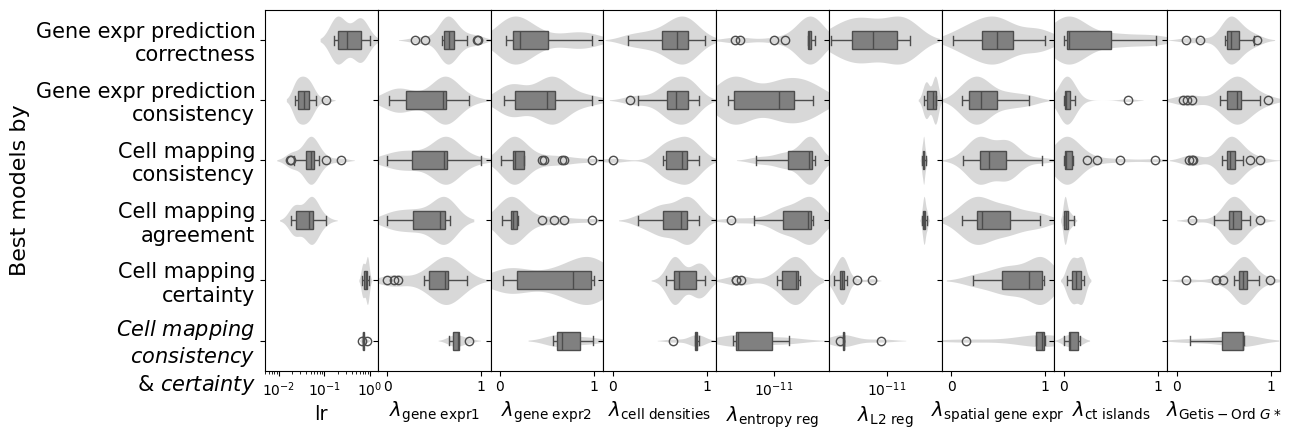

In [17]:
fig, axs = plt.subplots(1, 9, figsize=(13,4.5),sharey=True)
colors = ['green','orange','orange','orange','orange',
          "gray","gray","gray","gray","gray","gray","gray"]
vals = [
        "config/learning_rate",
        "config/lambda_g1",
        "config/lambda_g2",
        "config/lambda_d",
        "config/lambda_r","config/lambda_l2",
        "config/lambda_neighborhood_g1","config/lambda_ct_islands","config/lambda_getis_ord",
        ]
for val,ax,col in zip(vals,axs.flatten(),colors):
    #if val not in df_top.columns:
    #    continue
    if val in ["config/learning_rate","config/lambda_r","config/lambda_l1","config/lambda_l2"]:
        sns.violinplot(df_top2,x=val,y="metric",ax=ax, color="grey",#"#0065bd",
                       scale="count",#, count, width},
                        saturation=0.7,fill=True,alpha=0.3,linewidth=0,inner=None,#"box",
                       log_scale=True,#linewidth=0,
                       inner_kws=dict(box_width=6, whis_width=2))#,linecolor=col
        sns.boxplot(df_top2,x=val,y="metric",ax=ax, color="grey", width=0.3,#"#0065bd",
                    #   x='day', y='total_bill', data=tips, palette='turbo', width=0.3,
                    boxprops={'zorder': 2})
        ax.set_xscale('log')
        #ax.tick_params(axis='x', labelrotation=45)
        ax.set_xlim(xlimit[val])
    else: 
        sns.violinplot(df_top2,x=val,y="metric",
                    ax=ax, color="grey",#"#0065bd",
                    saturation=0.7,fill=True,alpha=0.3,linewidth=0,inner=None,#"box",
                    #saturation=0.7,fill=False,
                    scale="count",
                    inner_kws=dict(box_width=6, whis_width=2))#linewidth=0)
        sns.boxplot(df_top2,x=val,y="metric",ax=ax, color="grey", width=0.3,#"#0065bd",
                    #   x='day', y='total_bill', data=tips, palette='turbo', width=0.3,
                    boxprops={'zorder': 2})
    ax.set_ylabel("Best models by", fontsize=16)
    ax.tick_params(axis='y', labelsize=15)#, labelrotation=45)
    ax.set_xlabel(xlabel[val], fontsize=14)
    ax.set_xlim(xlimit[val])
    #plt.setp(ax.collections, alpha=.4)
    
    if val in ["cell_map_vote_entropy","cell_map_consensus_entropy"]:
        ax.xaxis.set_inverted(True)
plt.tight_layout()
plt.subplots_adjust(wspace=0)#hspace=0, 
plt.show()

In [19]:
vals = ["val_gene_score",
        "gene_corr",
        "cell_map_corr",
        "cell_map_vote_entropy",
        "cell_map_consensus_entropy"]
df_subset2 = pd.DataFrame()
for m in df_top2["metric"].unique():
        df_tmp = pd.DataFrame(df_top2[df_top2["metric"] == m][vals].mean()).T
        df_tmp.index = [m]
        df_subset2 = pd.concat([df_subset2,df_tmp])
df_subset2

,val_gene_score,gene_corr,cell_map_corr,cell_map_vote_entropy,cell_map_consensus_entropy
Gene expr prediction\ncorrectness,0.474302,0.990810,0.138463,0.837742,7.953051e-01
Gene expr prediction\nconsistency,0.473176,1.000000,0.987913,0.999803,5.811453e-07
Cell mapping\nconsistency,0.473180,1.000000,0.999998,0.997301,1.291931e-05
Cell mapping\nagreement,0.473175,1.000000,0.994856,0.999985,7.158518e-06
Cell mapping\ncertainty,0.463561,0.998181,0.750052,0.948005,9.093153e-01
\n$\it{Cell\ mapping}$\n$\it{consistency}$\n$\it{&\ certainty}$,0.464729,0.999036,0.857323,0.963319,8.993597e-01


In [20]:
metric_names1 = ['val_gene_score',]
metric_names2 = [
 'gene_corr',
 'cell_map_corr',
 ]
metric_names3 = [
 'cell_map_vote_entropy',
 ]

metric_names4 = [
 'cell_map_consensus_entropy',
 ]
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_cmap0 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "orange"])
custom_cmap3 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "xkcd:pumpkin orange"])
custom_cmap4 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "orangered"]) #"xkcd:bright orange"

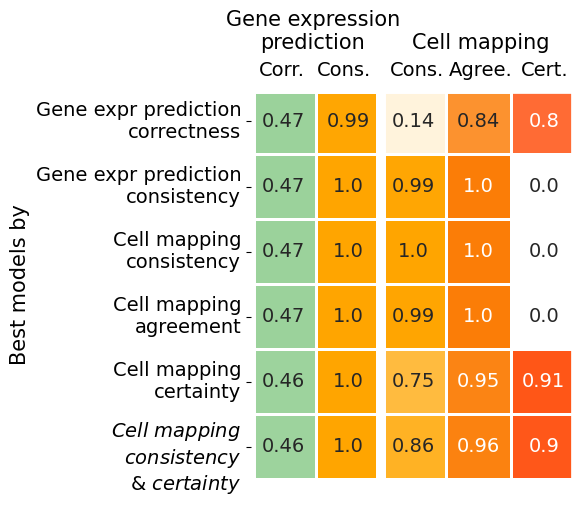

In [21]:
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.6*df_subset2.shape[0]+0.6, 1*df_subset2.shape[1]+1), 
                       sharey=True,)
ax.set_aspect("equal")
from matplotlib.patches import Rectangle
group_labels = ["Gene expression\nprediction","Cell mapping"]
group_labels2 = ["Correctness","Consistency", "Consistency","Agreement", "Certainty","Consistency", "Agreement", "Certainty"]
group_labels2 = ["Corr.","Cons.", "Cons.","Agree.", "Cert."]
group_positions = [[0,1],[2,4]]
ncols = df_subset2.shape[1]
nrows = df_subset2.shape[0] + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.3]
        for i in range(group_positions[g_idx][0], group_positions[g_idx][1]+1):
            ax.text(
                i-group_positions[g_idx][0]  + 0.5, -0.01 + (y) * 1.5,
                group_labels2[i],
                ha='center',# va="bottom", 
                color="black", size=14,#rotation=90,
            ) 
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.4, group, ha="center", va="bottom", 
            color="black",
            size=15,#rotation=90
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names1,metric_names2,metric_names3,metric_names4],
                                            [custom_cmap1,custom_cmap2,custom_cmap3,custom_cmap4]):
    data = df_subset2.copy()
    data.loc[:,list(set(df_subset2.columns)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1,#4, 
                annot=df_subset2.round(decimals=2).astype("str"), 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 14},
                vmin=0,vmax=1,
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.set_ylabel('Best models by', fontsize=15)
    ax.add_patch(Rectangle((0, 0), 2, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((2, 0), 3, 7, fill=False, edgecolor='white', lw=7))

In [7]:
adata_maps_pred = dict()
for model in ["all"]:#,"hvg","svg", "ctg", "hvg+svg+ctg"]:
    adata_maps_pred[model] = dict()
    for run in range(1):
        #adata_maps_pred[model][run] = an.AnnData(X=np.load(f'visium_mouse_cortex_gene_sets_testsplit/{model}/{run}.npy', allow_pickle=True), 
        adata_maps_pred[model][run] = an.AnnData(X=np.load(f'mapping/visium_mouse_cortex_genesets_default_{run}.npy', allow_pickle=True), 
                                                    obs=adata_sc.obs,
                                                    var=adata_st.obs)

In [6]:
for model in ["ctg"]:#,"hvg","svg", "ctg", "hvg+svg+ctg"]:
    adata_maps_pred[model] = dict()
    for run in range(1):
        #adata_maps_pred[model][run] = an.AnnData(X=np.load(f'visium_mouse_cortex_gene_sets_testsplit/{model}/{run}.npy', allow_pickle=True), 
        adata_maps_pred[model][run] = an.AnnData(X=np.load(f'mapping/visium_mouse_cortex_genesets_ctg_defaultparams_{run}.npy', allow_pickle=True), 
                                                    obs=adata_sc.obs,
                                                    var=adata_st.obs)

In [7]:
adata_maps_pred["constrained"] = dict()
run = 0
x = np.load(f'mapping/visium_mouse_cortex_constrained_defaultparams_{run}.npy', allow_pickle=True) * \
    np.load(f'mapping/visium_mouse_cortex_constrained_defaultparams_{run}_f.npy', allow_pickle=True)[:, np.newaxis]
adata_maps_pred["constrained"][run] = an.AnnData(X=x, 
                                                obs=adata_sc.obs,
                                                var=adata_st.obs)

In [18]:
test_genes = np.load("visium_mouse_cortex_split/test_genes_indices.npy", allow_pickle=True).tolist()
train_genes = np.load("visium_mouse_cortex_split/all_train_genes_indices.npy", allow_pickle=True).tolist()

### constrained

In [9]:
pred_gene_expr = adata_maps_pred["constrained"][0].X.T @ adata_sc[:,adata_sc.uns["overlap_genes"]].X
gene_expr = np.array(adata_st[:,adata_sc.uns["overlap_genes"]].X.todense())

In [ ]:
pd.DataFrame({"real" : gene_expr[:,test_genes].flatten(),
              "pred" : pred_gene_expr[:,test_genes].flatten()}).plot.scatter("real","pred")

In [ ]:
pd.DataFrame({"real" : gene_expr[:,train_genes].flatten(),
              "pred" : pred_gene_expr[:,train_genes].flatten()}).plot.scatter("real","pred")

### all correct error

In [ ]:
adata_maps_pred["ctg"][0].X.max(axis=1)

### all

In [12]:
model = "all"

In [13]:
pred_gene_expr = adata_maps_pred[model][0].X.T @ adata_sc[:,adata_sc.uns["overlap_genes"]].X
gene_expr = np.array(adata_st[:,adata_sc.uns["overlap_genes"]].X.todense())

In [ ]:
pd.DataFrame({"real" : gene_expr.flatten(),
              "pred" : pred_gene_expr.flatten()}).plot.scatter("real","pred")

In [ ]:
pd.DataFrame({"real" : gene_expr[:,test_genes].flatten(),
              "pred" : pred_gene_expr[:,test_genes].flatten()}).plot.scatter("real","pred")

In [ ]:
pd.DataFrame({"real" : gene_expr[:,train_genes].flatten(),
              "pred" : pred_gene_expr[:,train_genes].flatten()}).plot.scatter("real","pred")

#### ctg

In [84]:
pred_gene_expr2 = adata_maps_pred["ctg"][0].X.T @ adata_sc[:,markers].X
gene_expr2 = np.array(adata_st[:,markers].X.todense())

In [ ]:
pd.DataFrame({"real" : gene_expr2.flatten(),
              "pred" : pred_gene_expr2.flatten()}).plot.scatter("real","pred")

In [ ]:
pd.DataFrame({"real" : gene_expr[:,train_genes].flatten(),
              "pred" : pred_gene_expr[:,train_genes].flatten()}).plot.scatter("real","pred")

In [86]:
pred_gene_expr2 = pred_gene_expr2 - pred_gene_expr2.mean(axis=0)
gene_expr2 = gene_expr2 - gene_expr2.mean(axis=0)

In [ ]:
pd.DataFrame({"real" : gene_expr2.flatten(),
              "pred" : pred_gene_expr2.flatten()}).plot.scatter("real","pred")

In [ ]:
pd.DataFrame({"real" : gene_expr2[:,test_genes].flatten(),
              "pred" : pred_gene_expr2[:,test_genes].flatten()}).plot.scatter("real","pred")

#### metrics

In [9]:
with open('benchmarking/tangram_default_genesets_visium_mouse_cortex_genemetrics_allgenes.pkl', 'rb') as f:
    metrics = pickle.load(f)

In [10]:
adata_sc_overlap = adata_sc[:,adata_sc.uns["overlap_genes"]].copy()
adata_st_overlap = adata_st[:,adata_sc.uns["overlap_genes"]].copy()

In [23]:
adata_sc_overlap.var["gene_expr_corr"] = np.array(metrics["gene_expr_corr"]["ctg"])
adata_sc_overlap.var["gene_expr_cosine_sim"] = np.array(metrics["gene_expr_cosine_sim"]["ctg"]).mean(axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
pd.DataFrame({"corr" : np.array(metrics["gene_expr_runs_corr"]["ctg"]),
              "cosine sim" : np.array(metrics["gene_expr_runs_cosine_sim"]["ctg"]).mean(axis=0)}).plot.scatter("corr","cosine sim",ax=ax)
ax.plot([0,1], [0,1], zorder=-1)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
pd.DataFrame({"corr" : np.array(metrics["gene_expr_runs_corr"]["ctg"])[test_genes],
              "cosine sim" : np.array(metrics["gene_expr_runs_cosine_sim"]["ctg"]).mean(axis=0)[test_genes]}).plot.scatter("corr","cosine sim",ax=ax)
ax.plot([0,1], [0,1], zorder=-1)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
pd.DataFrame({"corr" : np.array(metrics["gene_expr_corr"]["ctg"]),
              "cosine sim" : np.array(metrics["gene_expr_cosine_sim"]["ctg"]).mean(axis=0)}).plot.scatter("corr","cosine sim",ax=ax)
ax.plot([0,1], [0,1], zorder=-1)
plt.show()

In [ ]:
df = pd.DataFrame({"corr" : np.array(metrics["gene_expr_corr"]["ctg"]),
                    "cosine sim" : np.array(metrics["gene_expr_cosine_sim"]["ctg"]).mean(axis=0),
                  })
sns.kdeplot(data=df, x='corr', y='cosine sim')

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
pd.DataFrame({"corr" : np.array(metrics["gene_expr_corr"]["ctg"])[test_genes],
              "cosine sim" : np.array(metrics["gene_expr_cosine_sim"]["ctg"]).mean(axis=0)[test_genes]}).plot.scatter("corr","cosine sim",ax=ax)
ax.plot([0,1], [0,1], zorder=-1)
plt.show()

In [26]:
mask = pred_gene_expr.round() != 0
gene_sparsity = mask.sum(axis=0) / adata_st_overlap.X.shape[0]
adata_sc_overlap.var["pred_sp_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()

In [29]:
mask = (adata_st_overlap.X.todense() != 0) & (pred_gene_expr.round() != 0)
gene_sparsity = mask.sum(axis=0) / adata_st_overlap.X.shape[0]
adata_sc_overlap.var["sp_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()


In [40]:
(adata_st_overlap.X != 0) + (pred_gene_expr.round() != 0)
gene_sparsity = mask.sum(axis=0) / adata_st_overlap.X.shape[0]
adata_sc_overlap.var["lol_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()

In [30]:
adata_sc_overlap.var["sparsity_diff"] = adata_sc_overlap.var["sp_sparsity"]-adata_sc_overlap.var["pred_sp_sparsity"]

In [131]:
adata_sc_overlap.var["sparsity_diff"] = np.array([adata_sc_overlap.var["sp_sparsity"],adata_sc_overlap.var["sc_sparsity"]]).min(axis=0)

In [169]:
adata_sc_overlap.var["sparsity_diff"] = adata_sc_overlap.var["lol_sparsity"]

In [68]:
adata_sc_overlap.var["sparsity_diff"] = np.abs(adata_sc_overlap.var["sp_sparsity"]-adata_sc_overlap.var["sc_sparsity"])

In [ ]:
df = pd.DataFrame({"corr" : np.array(metrics["gene_expr_corr"]["ctg"]),
                    "cosine sim" : np.array(metrics["gene_expr_cosine_sim"]["ctg"]).mean(axis=0),
                    "sparsity diff" : adata_sc_overlap.var["sparsity_diff"]})
sns.scatterplot(data=df, x='corr', y='cosine sim', hue='sparsity diff')

In [36]:
mask = adata_st_overlap.X != 0
gene_sparsity = mask.sum(axis=0) / adata_st_overlap.X.shape[0]
adata_sc_overlap.var["sp_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()

mask = adata_sc_overlap.X != 0
gene_sparsity = mask.sum(axis=0) / adata_sc_overlap.X.shape[0]
adata_sc_overlap.var["sc_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()

In [ ]:
pd.DataFrame({"corr" : np.array(metrics["gene_expr_corr"]["all"])[train_genes],
              "cosine sim" : np.array(metrics["gene_expr_cosine_sim"]["all"]).mean(axis=0)[train_genes]}).plot.scatter("corr","cosine sim")

In [ ]:
pd.DataFrame({"corr" : np.array(metrics["gene_expr_runs_corr"]["all"])[train_genes],
              "cosine sim" : np.array(metrics["gene_expr_runs_cosine_sim"]["all"]).mean(axis=0)[train_genes]}).plot.scatter("corr","cosine sim")

In [ ]:
pd.DataFrame({"corr" : np.array(metrics["gene_expr_runs_corr"]["all"]),
              "cosine sim" : np.array(metrics["gene_expr_runs_cosine_sim"]["all"]).mean(axis=0)}).plot.scatter("corr","cosine sim")

#### high low corr

In [ ]:
adata_st.X.sum(axis=0)

In [ ]:
adata_st.X.sum(axis=1)

In [15]:
pred_gene_expr = adata_maps_pred["all"][0].X.T @ adata_sc_overlap.X
gene_expr = np.array(adata_st_overlap.X.todense())

In [64]:
max_corr = np.array(adata_sc_overlap.var["gene_expr_corr"]).argmax()
min_corr = np.array(adata_sc_overlap.var["gene_expr_corr"]).argmin()

In [ ]:
pd.DataFrame({"real" : gene_expr[:,max_corr].flatten(),
              "pred" : pred_gene_expr[:,max_corr].flatten()}).plot.scatter("real","pred")

In [ ]:
pd.DataFrame({"real" : gene_expr[:,min_corr].flatten(),
              "pred" : pred_gene_expr[:,min_corr].flatten()}).plot.scatter("real","pred")

In [ ]:
df = pd.DataFrame({"real" : gene_expr[:,max_corr].flatten(),
                   "pred" : pred_gene_expr[:,max_corr].flatten()})
fig, (ax1, ax2) = plt.subplots(ncols=2,sharey=True)
sns.heatmap(pd.DataFrame(df["real"]),ax=ax1)
sns.heatmap(pd.DataFrame(df["pred"]),ax=ax2)

In [ ]:
df = pd.DataFrame({"real" : gene_expr[:,min_corr].flatten(),
                   "pred" : pred_gene_expr[:,min_corr].flatten()})
fig, (ax1, ax2) = plt.subplots(ncols=2,sharey=True)
import seaborn as sns
sns.heatmap(pd.DataFrame(df["real"]),ax=ax1)
sns.heatmap(pd.DataFrame(df["pred"]),ax=ax2)

In [70]:
max_corr = np.array(adata_sc_overlap.var["gene_expr_cosine_sim"]).argmax()
min_corr = np.array(adata_sc_overlap.var["gene_expr_cosine_sim"]).argmin()

In [ ]:
pd.DataFrame({"real" : gene_expr[:,max_corr].flatten(),
              "pred" : pred_gene_expr[:,max_corr].flatten()}).plot.scatter("real","pred")

In [ ]:
pd.DataFrame({"real" : gene_expr[:,min_corr].flatten(),
              "pred" : pred_gene_expr[:,min_corr].flatten()}).plot.scatter("real","pred")

In [ ]:
df = pd.DataFrame({"real" : gene_expr[:,max_corr].flatten(),
                   "pred" : pred_gene_expr[:,max_corr].flatten()})
fig, (ax1, ax2) = plt.subplots(ncols=2,sharey=True)
sns.heatmap(pd.DataFrame(df["real"]),ax=ax1)
sns.heatmap(pd.DataFrame(df["pred"]),ax=ax2)

In [ ]:
df = pd.DataFrame({"real" : gene_expr[:,min_corr].flatten(),
                   "pred" : pred_gene_expr[:,min_corr].flatten()})
fig, (ax1, ax2) = plt.subplots(ncols=2,sharey=True)
import seaborn as sns
sns.heatmap(pd.DataFrame(df["real"]),ax=ax1)
sns.heatmap(pd.DataFrame(df["pred"]),ax=ax2)

todo get index of overlapping genes

### Sparsity

In [11]:
mask = adata_st_overlap.X != 0
gene_sparsity = mask.sum(axis=0) / adata_st_overlap.X.shape[0]
adata_sc_overlap.var["sp_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()

mask = adata_sc_overlap.X != 0
gene_sparsity = mask.sum(axis=0) / adata_sc_overlap.X.shape[0]
adata_sc_overlap.var["sc_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()

In [12]:
adata_sc_overlap.var["sparsity_diff"] = adata_sc_overlap.var["sp_sparsity"]-adata_sc_overlap.var["sc_sparsity"]

In [ ]:
np.array(metrics["gene_expr_cosine_sim"]["ctg"]).shape

In [ ]:
np.array(metrics["gene_expr_voxel_cosine_sim"]["ctg"]).shape

In [ ]:
X_space = adata_maps_pred[model][0].X.T @ adata_sc.X
adata_ge = sc.AnnData(
        X=X_space, obs=adata_maps_pred[model][0].var, var=adata_sc.var, uns=adata_sc.uns
    )

In [39]:
df_all_genes = tg.compare_spatial_geneexp(adata_ge, adata_st)

In [ ]:
df_all_genes.plot.scatter("sparsity_sp","score")

In [ ]:
df_all_genes.loc[test_genes_names].plot.scatter("sparsity_sp","score")

In [43]:
test_genes_names = np.load("test_genes.npy", allow_pickle=True).tolist()

In [ ]:
metric_dict, auc_coordinates = tg.eval_metric(df_all_genes, test_genes=test_genes_names)

In [ ]:
metrics.keys()

In [ ]:
np.array(metrics["gene_expr_corr"][model]).shape

In [66]:
# COSINE STATT CORR
adata_sc_overlap.var["gene_expr_runs_corr"] = np.array(metrics["gene_expr_runs_corr"][model])#.mean(axis=0)
adata_sc_overlap.var["gene_expr_correct_corr"] = np.array(metrics["gene_expr_corr"][model])#[0]
#adata_sc_testoverlap.var["gene_expr_correct_corr"] = np.array(correctness_metrics["gene_expr_cosine_sim"]["all"]).mean(axis=0)

In [ ]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
#train_genes = adata_sc_overlap.var_names[all_train_genes_indices]
markers = list(set(markers).intersection(set(adata_sc.uns["overlap_genes"])))
#adata_sc_trainoverlap = adata_sc[:,markers]

In [13]:
test_genes = np.load("visium_mouse_cortex_split/test_genes.npy", allow_pickle=True).tolist()
train_genes = np.load("visium_mouse_cortex_split/all_train_genes.npy", allow_pickle=True).tolist()

In [35]:
with open('benchmarking/tangram_default_genesets_visium_mouse_cortex_genemetrics_testgenes.pkl', 'rb') as f:
    testmetrics = pickle.load(f)
with open('benchmarking/tangram_default_genesets_visium_mouse_cortex_genemetrics_traingenes.pkl', 'rb') as f:
    trainmetrics = pickle.load(f)

In [30]:
adata_sc_overlappop = adata_sc_overlap[:,test_genes]

In [31]:
# COSINE STATT CORR
adata_sc_overlappop.var["gene_expr_runs_corr"] = np.array(testmetrics["gene_expr_runs_corr"][model])
adata_sc_overlappop.var["gene_expr_correct_corr"] = np.array(testmetrics["gene_expr_corr"][model])

In [ ]:
import seaborn as sns 

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
df = adata_sc_overlappop.var
axs_f = axs#.flatten()

# set limits for axis
#axs_f[0].set_ylim([0.0, 1.0])
for i in range(0, 2):
    for j in range(1,4):
        axs_f[i][j].set_xlim([0.0, 1.0])
        #axs_f[i][j].set_ylim([0.0, 1.0])

#     axs_f[0].set_title('Training scores for single genes')
sns.histplot(
    data=df, 
    y="gene_expr_correct_corr", 
    bins=50, 
    ax=axs_f[0][0], 
    #color="coral"
)
axs_f[0][0].set_ylabel("gene expression \n correctness corr")


#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    alpha=0.5,
    #color="coral",
)

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sp_sparsity",
    ax=axs_f[0][2],
    alpha=0.5,
    #color="coral",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sparsity_diff",
    ax=axs_f[0][3],
    alpha=0.5,
    #color="coral",
)


for i in range(4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][i].set_xlabel("")
    axs_f[1][i].set_xlabel("")

for j in range(1,4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][j].set_ylabel("")
    axs_f[0][j].set_yticks([])
    axs_f[1][j].set_ylabel("")
    axs_f[1][j].set_yticks([])


sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=50, 
    ax=axs_f[1][0], 
    #color="coral"
)
axs_f[1][0].set_ylabel("gene expression \n inconsistency corr")
axs_f[1][0].set_xlabel("counts")

#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sc_sparsity",
    ax=axs_f[1][1],
    alpha=0.5,
    #color="coral",
)
axs_f[1][1].set_xlabel("sc sparsity")

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sp_sparsity",
    ax=axs_f[1][2],
    alpha=0.5,
    #color="coral",
)
axs_f[1][2].set_xlabel("sp sparsity")

sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sparsity_diff",
    ax=axs_f[1][3],
    alpha=0.5,
    #color="coral",
)
axs_f[1][3].set_xlabel("sparsity difference (sp - sc)")

plt.tight_layout()

In [36]:
adata_sc_overlappop = adata_sc_overlap[:,train_genes]

In [37]:
# COSINE STATT CORR
adata_sc_overlappop.var["gene_expr_runs_corr"] = np.array(trainmetrics["gene_expr_runs_corr"][model])
adata_sc_overlappop.var["gene_expr_correct_corr"] = np.array(trainmetrics["gene_expr_corr"][model])

In [ ]:
import seaborn as sns 

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
df = adata_sc_overlappop.var
axs_f = axs#.flatten()

# set limits for axis
#axs_f[0].set_ylim([0.0, 1.0])
for i in range(0, 2):
    for j in range(1,4):
        axs_f[i][j].set_xlim([0.0, 1.0])
        #axs_f[i][j].set_ylim([0.0, 1.0])

#     axs_f[0].set_title('Training scores for single genes')
sns.histplot(
    data=df, 
    y="gene_expr_correct_corr", 
    bins=50, 
    ax=axs_f[0][0], 
    #color="coral"
)
axs_f[0][0].set_ylabel("gene expression \n correctness corr")


#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    alpha=0.5,
    #color="coral",
)

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sp_sparsity",
    ax=axs_f[0][2],
    alpha=0.5,
    #color="coral",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sparsity_diff",
    ax=axs_f[0][3],
    alpha=0.5,
    #color="coral",
)


for i in range(4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][i].set_xlabel("")
    axs_f[1][i].set_xlabel("")

for j in range(1,4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][j].set_ylabel("")
    axs_f[0][j].set_yticks([])
    axs_f[1][j].set_ylabel("")
    axs_f[1][j].set_yticks([])


sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=50, 
    ax=axs_f[1][0], 
    #color="coral"
)
axs_f[1][0].set_ylabel("gene expression \n inconsistency corr")
axs_f[1][0].set_xlabel("counts")

#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sc_sparsity",
    ax=axs_f[1][1],
    alpha=0.5,
    #color="coral",
)
axs_f[1][1].set_xlabel("sc sparsity")

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sp_sparsity",
    ax=axs_f[1][2],
    alpha=0.5,
    #color="coral",
)
axs_f[1][2].set_xlabel("sp sparsity")

sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sparsity_diff",
    ax=axs_f[1][3],
    alpha=0.5,
    #color="coral",
)
axs_f[1][3].set_xlabel("sparsity difference (sp - sc)")

plt.tight_layout()

In [ ]:
np.array(metrics["gene_expr_voxel_runs_cosine_sim"]["all"]).shape

In [27]:
# COSINE STATT CORR
adata_sc_overlap.var["gene_expr_runs_corr"] = np.array(metrics["gene_expr_runs_cosine_sim"]["all"]).mean(axis=0)
adata_sc_overlap.var["gene_expr_correct_corr"] = np.array(metrics["gene_expr_cosine_sim"]["all"]).mean(axis=0)
#adata_sc_testoverlap.var["gene_expr_correct_corr"] = np.array(correctness_metrics["gene_expr_cosine_sim"]["all"]).mean(axis=0)

In [17]:
adata_sc_overlappop = adata_sc_overlap[:,test_genes]

In [33]:
adata_sc_overlappop.var["gene_expr_runs_corr"] = np.array(testmetrics["gene_expr_runs_cosine_sim"]["all"]).mean(axis=0)
adata_sc_overlappop.var["gene_expr_correct_corr"] = np.array(testmetrics["gene_expr_cosine_sim"]["all"]).mean(axis=0)

In [ ]:
import seaborn as sns 

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
df = adata_sc_overlappop.var
axs_f = axs#.flatten()

# set limits for axis
#axs_f[0].set_ylim([0.0, 1.0])
for i in range(0, 2):
    for j in range(1,4):
        axs_f[i][j].set_xlim([0.0, 1.0])
        #axs_f[i][j].set_ylim([0.0, 1.0])

#     axs_f[0].set_title('Training scores for single genes')
sns.histplot(
    data=df, 
    y="gene_expr_correct_corr", 
    bins=50, 
    ax=axs_f[0][0], 
    #color="coral"
)
axs_f[0][0].set_ylabel("gene expression \n correctness corr")


#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    alpha=0.5,
    #color="coral",
)

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sp_sparsity",
    ax=axs_f[0][2],
    alpha=0.5,
    #color="coral",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sparsity_diff",
    ax=axs_f[0][3],
    alpha=0.5,
    #color="coral",
)


for i in range(4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][i].set_xlabel("")
    axs_f[1][i].set_xlabel("")

for j in range(1,4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][j].set_ylabel("")
    axs_f[0][j].set_yticks([])
    axs_f[1][j].set_ylabel("")
    axs_f[1][j].set_yticks([])


sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=50, 
    ax=axs_f[1][0], 
    #color="coral"
)
axs_f[1][0].set_ylabel("gene expression \n inconsistency corr")
axs_f[1][0].set_xlabel("counts")

#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sc_sparsity",
    ax=axs_f[1][1],
    alpha=0.5,
    #color="coral",
)
axs_f[1][1].set_xlabel("sc sparsity")

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sp_sparsity",
    ax=axs_f[1][2],
    alpha=0.5,
    #color="coral",
)
axs_f[1][2].set_xlabel("sp sparsity")

sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sparsity_diff",
    ax=axs_f[1][3],
    alpha=0.5,
    #color="coral",
)
axs_f[1][3].set_xlabel("sparsity difference (sp - sc)")

plt.tight_layout()

In [ ]:
adata_sc_overlappop = adata_sc_overlap[:,train_genes]

In [39]:
adata_sc_overlappop.var["gene_expr_runs_corr"] = np.array(trainmetrics["gene_expr_runs_cosine_sim"]["all"]).mean(axis=0)
adata_sc_overlappop.var["gene_expr_correct_corr"] = np.array(trainmetrics["gene_expr_cosine_sim"]["all"]).mean(axis=0)

In [ ]:
import seaborn as sns 

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
df = adata_sc_overlappop.var
axs_f = axs#.flatten()

# set limits for axis
#axs_f[0].set_ylim([0.0, 1.0])
for i in range(0, 2):
    for j in range(1,4):
        axs_f[i][j].set_xlim([0.0, 1.0])
        #axs_f[i][j].set_ylim([0.0, 1.0])

#     axs_f[0].set_title('Training scores for single genes')
sns.histplot(
    data=df, 
    y="gene_expr_correct_corr", 
    bins=50, 
    ax=axs_f[0][0], 
    #color="coral"
)
axs_f[0][0].set_ylabel("gene expression \n correctness corr")


#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    alpha=0.5,
    #color="coral",
)

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sp_sparsity",
    ax=axs_f[0][2],
    alpha=0.5,
    #color="coral",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sparsity_diff",
    ax=axs_f[0][3],
    alpha=0.5,
    #color="coral",
)


for i in range(4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][i].set_xlabel("")
    axs_f[1][i].set_xlabel("")

for j in range(1,4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][j].set_ylabel("")
    axs_f[0][j].set_yticks([])
    axs_f[1][j].set_ylabel("")
    axs_f[1][j].set_yticks([])


sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=50, 
    ax=axs_f[1][0], 
    #color="coral"
)
axs_f[1][0].set_ylabel("gene expression \n inconsistency corr")
axs_f[1][0].set_xlabel("counts")

#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sc_sparsity",
    ax=axs_f[1][1],
    alpha=0.5,
    #color="coral",
)
axs_f[1][1].set_xlabel("sc sparsity")

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sp_sparsity",
    ax=axs_f[1][2],
    alpha=0.5,
    #color="coral",
)
axs_f[1][2].set_xlabel("sp sparsity")

sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sparsity_diff",
    ax=axs_f[1][3],
    alpha=0.5,
    #color="coral",
)
axs_f[1][3].set_xlabel("sparsity difference (sp - sc)")

plt.tight_layout()

In [ ]:
import seaborn as sns 

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
df = adata_sc_overlap.var
axs_f = axs#.flatten()

# set limits for axis
#axs_f[0].set_ylim([0.0, 1.0])
for i in range(0, 2):
    for j in range(1,4):
        axs_f[i][j].set_xlim([0.0, 1.0])
        #axs_f[i][j].set_ylim([0.0, 1.0])

#     axs_f[0].set_title('Training scores for single genes')
sns.histplot(
    data=df, 
    y="gene_expr_correct_corr", 
    bins=50, 
    ax=axs_f[0][0], 
    #color="coral"
)
axs_f[0][0].set_ylabel("gene expression \n correctness corr")


#axs_f[1].set_title("score vs sparsity (single cells)")
"""sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    alpha=0.5,
    #color="coral",
)"""
sns.regplot(data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    ci=None,
    line_kws=dict(color="r"),
    scatter_kws=dict(alpha=0.05),
    order=2
    )

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.regplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sp_sparsity",
    ax=axs_f[0][2],
    ci=None,
    line_kws=dict(color="r"),
    scatter_kws=dict(alpha=0.05),
    order=2
)

sns.regplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sparsity_diff",
    ax=axs_f[0][3],
    ci=None,
    line_kws=dict(color="r"),
    scatter_kws=dict(alpha=0.05),
    order=2
    #color="coral",
)


for i in range(4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][i].set_xlabel("")
    axs_f[1][i].set_xlabel("")

for j in range(1,4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][j].set_ylabel("")
    axs_f[0][j].set_yticks([])
    axs_f[1][j].set_ylabel("")
    axs_f[1][j].set_yticks([])


sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=50, 
    ax=axs_f[1][0], 
    #color="coral"
)
axs_f[1][0].set_ylabel("gene expression \n inconsistency corr")
axs_f[1][0].set_xlabel("counts")

#axs_f[1].set_title("score vs sparsity (single cells)")
sns.regplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sc_sparsity",
    ax=axs_f[1][1],
    ci=None,
    line_kws=dict(color="r"),
    scatter_kws=dict(alpha=0.05),
    order=2
)
axs_f[1][1].set_xlabel("sc sparsity")

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.regplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sp_sparsity",
    ax=axs_f[1][2],
    ci=None,
    line_kws=dict(color="r"),
    scatter_kws=dict(alpha=0.05),
    order=2
)
axs_f[1][2].set_xlabel("sp sparsity")

sns.regplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sparsity_diff",
    ax=axs_f[1][3],
    ci=None,
    line_kws=dict(color="r"),
    scatter_kws=dict(alpha=0.05),
    order=2
)
axs_f[1][3].set_xlabel("sparsity difference (sp - sc)")

plt.tight_layout()

In [200]:
with open('benchmarking/tangram_default_genesets_visium_mouse_cortex_metrics_traingenes.pkl', 'rb') as f:
    metrics = pickle.load(f)

In [43]:
all_train_genes_indices = np.load("all_train_genes_indices.npy", allow_pickle=True).tolist()

In [ ]:
train_genes = adata_sc_overlap.var_names[all_train_genes_indices]
adata_sc_trainoverlap = adata_sc_overlap[:,train_genes]
adata_sc_trainoverlap.var["gene_expr_runs_corr"] = np.array(metrics["gene_expr_runs_corr"]["all"])#.mean(axis=0)
adata_sc_trainoverlap.var["gene_expr_correct_corr"] = np.array(metrics["gene_expr_corr"]["all"])#.mean(axis=0)

In [26]:
mask = (adata_st_overlap.X - adata_st_overlap.X.mean(axis=0)) != 0
gene_sparsity = mask.sum(axis=0) / adata_st_overlap.X.shape[0]
adata_sc_overlap.var["sp_sparsity"] = np.array(adata_st_overlap.X - adata_st_overlap.X.mean(axis=0)).min(axis=0)

mask = adata_sc_overlap.X != 0
gene_sparsity = mask.sum(axis=0) / adata_sc_overlap.X.shape[0]
adata_sc_overlap.var["sc_sparsity"] = np.array(1 - gene_sparsity.reshape((-1,))).flatten()

In [ ]:
np.array(adata_st_overlap.X)

In [37]:
adata_sc_overlap.var["sp_sparsity"] = np.array(adata_st_overlap.X.todense()).mean(axis=0)

In [108]:
adata_sc_overlap.var["sparsity_diff"] = adata_sc_overlap.var["sp_sparsity"]-adata_sc_overlap.var["sc_sparsity"]

In [ ]:
import seaborn as sns 

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
df = adata_sc_overlap.var
axs_f = axs#.flatten()

# set limits for axis
#axs_f[0].set_ylim([0.0, 1.0])
#for i in range(0, 2):
#    for j in range(1,4):
#        axs_f[i][j].set_xlim([0.0, 1.0])
        #axs_f[i][j].set_ylim([0.0, 1.0])

#     axs_f[0].set_title('Training scores for single genes')
sns.histplot(
    data=df, 
    y="gene_expr_correct_corr", 
    bins=50, 
    ax=axs_f[0][0], 
    #color="coral"
)
axs_f[0][0].set_ylabel("gene expression \n correctness corr")


#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    alpha=0.5,
    #color="coral",
)

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sp_sparsity",
    ax=axs_f[0][2],
    alpha=0.5,
    #color="coral",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sparsity_diff",
    ax=axs_f[0][3],
    alpha=0.5,
    #color="coral",
)


for i in range(4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][i].set_xlabel("")
    axs_f[1][i].set_xlabel("")

for j in range(1,4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][j].set_ylabel("")
    axs_f[0][j].set_yticks([])
    axs_f[1][j].set_ylabel("")
    axs_f[1][j].set_yticks([])


sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=50, 
    ax=axs_f[1][0], 
    #color="coral"
)
axs_f[1][0].set_ylabel("gene expression \n inconsistency corr")
axs_f[1][0].set_xlabel("counts")

#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sc_sparsity",
    ax=axs_f[1][1],
    alpha=0.5,
    #color="coral",
)
axs_f[1][1].set_xlabel("sc sparsity")

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sp_sparsity",
    ax=axs_f[1][2],
    alpha=0.5,
    #color="coral",
)
axs_f[1][2].set_xlabel("sp sparsity")

sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sparsity_diff",
    ax=axs_f[1][3],
    alpha=0.5,
    #color="coral",
)
axs_f[1][3].set_xlabel("sparsity difference (sp - sc)")

plt.tight_layout()

In [ ]:
import seaborn as sns 

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
df = adata_sc_overlap.var
axs_f = axs#.flatten()

# set limits for axis
#axs_f[0].set_ylim([0.0, 1.0])
#for i in range(0, 2):
#    for j in range(1,4):
#        axs_f[i][j].set_xlim([0.0, 1.0])
        #axs_f[i][j].set_ylim([0.0, 1.0])

#     axs_f[0].set_title('Training scores for single genes')
sns.histplot(
    data=df, 
    y="gene_expr_correct_corr", 
    bins=50, 
    ax=axs_f[0][0], 
    #color="coral"
)
axs_f[0][0].set_ylabel("gene expression score")


#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sc_sparsity",
    ax=axs_f[0][1],
    alpha=0.5,
    #color="coral",
)

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sp_sparsity",
    ax=axs_f[0][2],
    alpha=0.5,
    #color="coral",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_corr",
    x="sparsity_diff",
    ax=axs_f[0][3],
    alpha=0.5,
    #color="coral",
)


for i in range(4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][i].set_xlabel("")
    axs_f[1][i].set_xlabel("")

for j in range(1,4):
    #axs_f[0][i].set_xticks([])
    axs_f[0][j].set_ylabel("")
    axs_f[0][j].set_yticks([])
    axs_f[1][j].set_ylabel("")
    axs_f[1][j].set_yticks([])


sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=50, 
    ax=axs_f[1][0], 
    #color="coral"
)
axs_f[1][0].set_ylabel("gene expression correlation")
axs_f[1][0].set_xlabel("counts")

#axs_f[1].set_title("score vs sparsity (single cells)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sc_sparsity",
    ax=axs_f[1][1],
    alpha=0.5,
    #color="coral",
)
axs_f[1][1].set_xlabel("sc sparsity")

#axs_f[2].set_title("score vs sparsity (spatial)")
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sp_sparsity",
    ax=axs_f[1][2],
    alpha=0.5,
    #color="coral",
)
axs_f[1][2].set_xlabel("sp sparsity")

sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="sparsity_diff",
    ax=axs_f[1][3],
    alpha=0.5,
    #color="coral",
)
axs_f[1][3].set_xlabel("sparsity difference (sp - sc)")

plt.tight_layout()

In [200]:
with open('benchmarking/tangram_mod_seqfish_mouse_embryo.pkl', 'rb') as f:
    metrics = pickle.load(f)

In [219]:
with open('benchmarking/tangram_mod_seqfish_mouse_embryo_all_cells.pkl', 'rb') as f:
    metrics = pickle.load(f)

In [220]:
#preprocess
m = 'ct_map_vote_entropy'
for model in metrics[m].keys():
    metrics[m][model] = np.array(metrics[m][model]).mean(axis=1)
m = 'cell_map_cross_entropy'
for model in metrics[m].keys():
    metrics[m][model] = (np.array(metrics[m][model]) / (np.log(1140)*2)).mean(axis=0)
m = 'ct_map_consensus_entropy'
for model in metrics[m].keys():
    metrics[m][model] = np.array(metrics[m][model]).mean(axis=1)
m = "gene_expr_cosine_sim"
for model in metrics[m].keys():
    metrics[m][model] = np.array(metrics[m][model]).mean(axis=0)
for m in ['cell_map_cross_entropy',
    'cell_map_vote_entropy',
            'ct_map_vote_entropy',
            'cell_map_consensus_entropy',
            'ct_map_consensus_entropy']:
    for model in metrics[m].keys():
        metrics[m][model] = 1-np.array(metrics[m][model])

In [224]:
metrics["cell_map_cross_entropy"]["random"] = [0] * len(metrics["cell_map_cross_entropy"]["random"])

In [ ]:
np.log(1034)*2

In [ ]:
(np.array(metrics["cell_map_cross_entropy"]["random"]))

In [188]:
metric_names = [#'cell_map_spatial_var',
 #'ct_map_spatial_var',
 #'gene_expr_spatial_var',
 'gene_expr_cosine_sim',
 "cell_map_cross_entropy",
 'g_gene_expr_corr',
 'c_cell_map_corr',
 'c_ct_map_corr',
 'cell_map_vote_entropy',
 'ct_map_vote_entropy',
 'cell_map_consensus_entropy',
 'ct_map_consensus_entropy']

In [243]:
metric_labels = {
'gene_expr_cosine_sim' : "gene expression cosine similarity",
 'gene_expr_corr' : "gene expression correlation",
 'g_gene_expr_corr' : "gene expression correlation",
 "cell_map_cross_entropy" : "cell map cross entropy", 
 'cell_map_corr' : "cell map correlation",
 'c_cell_map_corr' : "cell map correlation",
 'ct_map_corr' : "celltype map correlation",
 'c_ct_map_corr' : "celltype map correlation",
 'cell_map_vote_entropy': "cell map vote entropy",
 "ct_map_vote_entropy": "celltype map vote entropy",
 'cell_map_consensus_entropy' : "cell map consensus entropy",
 'ct_map_consensus_entropy' : "celltype map consensus entropy"}

In [106]:
models = ["orig","random", "sparsity_cosine_similarity", "neighborhood_cosine_similarity", "ct_island", "getis_ord_g_star", "moran", "constrained_pretraining"]
model_labels = {"random" : "random", "orig" : "vanilla", 
                "sparsity_cosine_similarity" : "sparsity\ncosine similarity", 
                "neighborhood_cosine_similarity" : "neighborhood\ncosine similarity", 
                "neighborhood_cosine_similarity0" : "neighborhood\ncosine similarity", 
                "ct_island" : "celltype islands", 
                "getis_ord_g_star" : "Getis-ord G*", 
                "moran" : "Moran's I", 
                "constrained_pretraining" : "constrained\npretraining", 
                "constrained":"constrained", 
                "cytospace_preprocess": "cytospace preprocessing"}

In [ ]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

pvalues = {}
ttest_mode = ["greater","greater","greater","greater","greater","greater","less","less"]
for i in range(len(metric_names)):
    m = metric_names[i]
    pvalues[m] = []
    for mo in list(metrics[m].keys()):
        _,pvalue = scipy.stats.ttest_ind(metrics[m][mo], metrics[m]["orig"], alternative="greater")
        pvalues[m].append(convert_pvalue_to_asterisks(pvalue))
pd.DataFrame(pvalues, index=list(metrics[m].keys()))

In [ ]:
models = ["orig","random", "sparsity_cosine_similarity", "neighborhood_cosine_similarity0", "ct_island", "getis_ord_g_star", "moran"]
model_labels = {"random" : "random", "orig" : "vanilla", 
                "sparsity_cosine_similarity" : "sparsity\ncosine similarity", 
                "neighborhood_cosine_similarity" : "neighborhood\ncosine similarity", 
                "neighborhood_cosine_similarity0" : "neighborhood\ncosine similarity", 
                "ct_island" : "celltype islands", 
                "ct_island0" : "celltype islands", 
                "getis_ord_g_star" : "Getis-ord G*", 
                "moran" : "Moran's I", 
                "constrained_pretraining" : "constrained\npretraining", 
                "constrained":"constrained", 
                "cytospace_preprocess": "cytospace preprocessing"}
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

pvalues = {}
ttest_mode = ["greater","greater","greater","greater","greater","greater","less","less"]
for i in range(len(metric_names)):
    m = metric_names[i]
    pvalues[m] = []
    for mo in models:
        _,pvalue = scipy.stats.ttest_ind(metrics[m][mo], metrics[m]["orig"], alternative="greater")
        pvalues[m].append(convert_pvalue_to_asterisks(pvalue))
pd.DataFrame(pvalues, index=models)

In [226]:
import pandas as pd
import matplotlib
import matplotlib.patheffects as path_effects
import seaborn as sns

def add_median_labels(ax, pvalues, fmt='.1f'):
    """Credits: https://stackoverflow.com/a/63295846/4865723
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median,pvalue in zip(lines[4:len(lines):lines_per_box],pvalues):
        x, y = (data.mean() for data in median.get_data())
        x=1.1
        # choose value depending on horizontal or vertical plot orientation
        #value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{pvalue}', ha='center', va='center', #fontweight='bold',
                        color='#1f77b4',fontsize=7)
        # create median-colored border around white text for contrast
        #text.set_path_effects([
        #    path_effects.Stroke(linewidth=3, foreground="darkblue"),# foreground=median.get_color()),
        #    path_effects.Normal(),
        #])

In [ ]:
metric_names = [#'cell_map_spatial_var',
 #'ct_map_spatial_var',
 #'gene_expr_spatial_var',
 #"sparsity_gene_expr_cosine_sim",
 "cell_map_cross_entropy",
 'gene_expr_cosine_sim',
 'g_gene_expr_corr',
 'c_cell_map_corr',
 'c_ct_map_corr',
 'cell_map_vote_entropy',
 'ct_map_vote_entropy',
 'cell_map_consensus_entropy',
 'ct_map_consensus_entropy']
metric_labels = {
'gene_expr_cosine_sim' : "gene expression\n cosine similarity",
"cell_map_cross_entropy" : "cell map\ncross entropy", 
"sparsity_gene_expr_cosine_sim" : "sp sparsity weighted gene expression cosine similarity",
 'gene_expr_corr' : "gene expression correlation",
 'g_gene_expr_corr' : "gene expression\n pearson corr",
 'cell_map_corr' : "cell map correlation",
 'c_cell_map_corr' : "cell map\n pearson corr",
 'ct_map_corr' : "celltype map correlation",
 'c_ct_map_corr' : "cell type map\n pearson corr",
 'cell_map_vote_entropy': "cell map\n vote entropy",
 "ct_map_vote_entropy": "cell type map\n vote entropy",
 'cell_map_consensus_entropy' : "cell map\n consensus entropy",
 'ct_map_consensus_entropy' : "cell type map\n consensus entropy"}
fig, axes = plt.subplots(1, len(metric_names), figsize=(16,4.7), sharey=True) #(3*len(metric_names),6)
for i in range(len(metric_names)):
    m = metric_names[i]
    model = []
    values = []
    for mo in models:
        model += [model_labels[mo]] * len(metrics[m][mo])
        values.extend(metrics[m][mo])
    df = pd.DataFrame({"model": model, m : values})
    sns.boxplot(df, x=m, y="model", hue="model", ax=axes[i], legend=False)
    axes[i].set_xlabel(metric_labels[m])
    axes[i].set_ylabel("")
    #axes[i].set_title(metric_labels[m])
    #axes[i].set(xlim=(-0.05, 1.05))
    #if i > 3:
    #    axes[i].xaxis.set_inverted(True)
    axes[i].set(xlim=(-0.09, 1.22))
    if i==0 or i > 4:
        axes[i].set_xticklabels([1.0,1.0,0.5,0.0])
        #axes[i].set_xticklabels([1.0,1.0,0.8,0.6,0.4,0.2,0.0])
    add_median_labels(axes[i],pvalues[m])
    axes[i].tick_params(axis='y', which='major', labelsize=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
metric_names = [#'cell_map_spatial_var',
 #'ct_map_spatial_var',
 #'gene_expr_spatial_var',
 #"sparsity_gene_expr_cosine_sim",
 "cell_map_cross_entropy",
 'gene_expr_cosine_sim',
 'g_gene_expr_corr',
 'c_cell_map_corr',
 'c_ct_map_corr',
 'cell_map_vote_entropy',
 'ct_map_vote_entropy',
 'cell_map_consensus_entropy',
 'ct_map_consensus_entropy']
metric_labels = {
'gene_expr_cosine_sim' : "$\mathbf{correctness}$\n gene expression\n cosine similarity",
"cell_map_cross_entropy" : "$\mathbf{correctness}$\ncell map\ncross entropy", 
"sparsity_gene_expr_cosine_sim" : "sp sparsity weighted gene expression cosine similarity",
 'gene_expr_corr' : "gene expression correlation",
 'g_gene_expr_corr' : "$\mathbf{robustness}$\n gene expression\n pearson corr",
 'cell_map_corr' : "cell map correlation",
 'c_cell_map_corr' : "$\mathbf{robustness}$\n cell map\n pearson corr",
 'ct_map_corr' : "celltype map correlation",
 'c_ct_map_corr' : "$\mathbf{robustness}$\n cell type map\n pearson corr",
 'cell_map_vote_entropy': "$\mathbf{agreement}$\n cell map\n vote entropy",
 "ct_map_vote_entropy": "$\mathbf{agreement}$\n cell type map\n vote entropy",
 'cell_map_consensus_entropy' : "$\mathbf{certainty}$\n cell map\n consensus entropy",
 'ct_map_consensus_entropy' : "$\mathbf{certainty}$\n cell type map\n consensus entropy"}
fig, axes = plt.subplots(1, len(metric_names), figsize=(16,4.7), sharey=True) #(3*len(metric_names),6)
for i in range(len(metric_names)):
    m = metric_names[i]
    model = []
    values = []
    for mo in models:
        model += [model_labels[mo]] * len(metrics[m][mo])
        values.extend(metrics[m][mo])
    df = pd.DataFrame({"model": model, m : values})
    sns.boxplot(df, x=m, y="model", hue="model", ax=axes[i], legend=False)
    axes[i].set_xlabel(metric_labels[m])
    axes[i].set_ylabel("")
    #axes[i].set_title(metric_labels[m])
    #axes[i].set(xlim=(-0.05, 1.05))
    #if i > 3:
    #    axes[i].xaxis.set_inverted(True)
    axes[i].set(xlim=(-0.09, 1.22))
    if i==0 or i > 4:
        axes[i].set_xticklabels([1.0,1.0,0.5,0.0])
        #axes[i].set_xticklabels([1.0,1.0,0.8,0.6,0.4,0.2,0.0])
    add_median_labels(axes[i],pvalues[m])
    axes[i].tick_params(axis='y', which='major', labelsize=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:

fig, axes = plt.subplots(1, len(metric_names), figsize=(3*len(metric_names),6), sharey=True)
for i in range(len(metric_names)):
    m = metric_names[i]
    model = []
    values = []
    for mo in models:
        model += [model_labels[mo]] * len(metrics[m][mo])
        values.extend(metrics[m][mo])
    df = pd.DataFrame({"model": model, m : values})
    sns.boxplot(df, x=m, y="model", hue="model", ax=axes[i], legend=False)
    axes[i].set_xlabel(metric_labels[m])
    axes[i].set_ylabel("")
    #axes[i].set_title(metric_labels[m])
    #axes[i].set(xlim=(-0.05, 1.05))
    #if i > 3:
    #    axes[i].xaxis.set_inverted(True)
    axes[i].set(xlim=(-0.09, 1.19))
    if i==1 or i > 4:
        axes[i].set_xticklabels([1.0,1.0,0.5,0.0])
        #axes[i].set_xticklabels([1.0,1.0,0.8,0.6,0.4,0.2,0.0])
    add_median_labels(axes[i],pvalues[m])
    axes[i].tick_params(axis='y', which='major', labelsize=19)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:

fig, axes = plt.subplots(1, len(metric_names), figsize=(4*len(metric_names),4.5), sharey=True)
for i in range(len(metric_names)):
    m = metric_names[i]
    model = []
    values = []
    for mo in metrics[m].keys():
        model += [mo] * len(metrics[m][mo])
        values.extend(metrics[m][mo])
    df = pd.DataFrame({"model": model, m : values})
    sns.boxplot(df, x=m, y="model", hue="model", ax=axes[i], legend=False)
    axes[i].set_xlabel(metric_labels[m])
    axes[i].set_ylabel("cell type")
    #axes[i].set_title(metric_labels[m])
    axes[i].set(xlim=(-0.05, 1.05))
    if i > 3:
        axes[i].xaxis.set_inverted(True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()